exp007

dataloaderのget_img_gridでローパスフィルタ

In [30]:
import gc
import os
import random
import time
import math

import cv2
import numpy as np
import matplotlib.pyplot as plt

# model
import torch
import torchvision
import torch.nn as nn
import timm
from torchvision.models.feature_extraction import create_feature_extractor
import torchvision.transforms.functional as TF

# data loader
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import DataLoader, Dataset

# training
from torch.optim import SGD, Adam, AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR, CosineAnnealingWarmRestarts, ReduceLROnPlateau

# metric
from sklearn.metrics import fbeta_score, roc_auc_score

import wandb

# config

In [31]:
BASE_DIR = "/working/"
INPUT_DIR = os.path.join(BASE_DIR, "input", "vesuvius-challenge-ink-detection")
TRAIN_DIR = os.path.join(INPUT_DIR, "train")
TEST_DIR = os.path.join(INPUT_DIR, "test")

SURFACE_LIST = [
                range(26, 36, 3),
                range(27, 37, 3),                
                range(25, 35, 3),
                ]
print(len(SURFACE_LIST[0]))
print(SURFACE_LIST)

SURFACE_NUM = len(SURFACE_LIST[0])
# print("Start surface idx =",START_SURFACE)


CFG = {
    "DEBUG" : False,
    # exp setting
    "EXP_CATEGORY" : "makebase",
    "EXP_NAME" : "exp007",
    "folds" : [0, 1, 2],

    # model
    # "model_name" : "tf_efficientnet_b0",
    "model_name" : "tf_efficientnet_b6",
    "inp_channels" : SURFACE_NUM,
    "out_channels" : 1,
    "pretrained" : True,
    "out_indices" : [0,1,2,3,4],
 
    # data   
    "img_size": [256, 256],
    # "batch_size": 64,
    "batch_size": 16,#batch normの関係か？16の方が64より安定してそう？？
    "INPUT_DIR": INPUT_DIR,
    "TRAIN_DIR": TRAIN_DIR,
    "TEST_DIR": TEST_DIR,
    "surface_num": SURFACE_NUM,
#     "surface_start_idx": START_SURFACE,
    "TRAIN_DIR_LIST": [["1", "2"], ["1", "3"], ["2", "3"]],
#     "TRAIN_IDX_LIST" : ["1"],
    "VALID_DIR_LIST": [["3"],["2"],["1"]],
    "TEST_DIR_LIST": ["a", "b"],

    # learning
    "n_epoch" : 15,
    "lr" : 7.5e-4,
    "T_max" : 10,
    "min_lr" : 1e-8,
    "weight_decay" : 1e-6,

    # etc
    "print_freq" : 1000,
    "random_seed" : 21,
    "num_workers": 2,
}

if CFG["model_name"]=="tf_efficientnet_b0":
    CFG["channel_nums"] = [320, 112, 40, 24, 16]
elif CFG["model_name"]=="tf_efficientnet_b4":
    CFG["channel_nums"] = [448, 160, 56, 32, 24]
elif CFG["model_name"]=="tf_efficientnet_b6":
    CFG["channel_nums"] = [576, 200, 72, 40, 32]


if CFG["DEBUG"]:
    CFG["n_epoch"] = 2
    CFG["EXP_NAME"] = "DEBUG"

4
[range(26, 36, 3), range(27, 37, 3), range(25, 35, 3)]


In [32]:
CFG["OUTPUT_DIR"] = os.path.join(BASE_DIR, "output", CFG["EXP_NAME"])
os.makedirs(CFG["OUTPUT_DIR"])

In [33]:
os.environ["WANDB_SILENT"] = "true"
WANDB_CONFIG = {'competition': 'vcid', '_wandb_kernel': 'taro'}
wandb.init(project=WANDB_CONFIG["competition"], config=CFG, group=CFG["EXP_CATEGORY"], name=CFG["EXP_NAME"])

2023-04-15 14:09:43.931049: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-15 14:09:44.007193: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-15 14:09:44.585463: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib/python3.7/site-packages/cv2/../../lib64:/usr/local/cuda/lib64:/usr/local/cuda/lib:/

# utils

In [34]:
def logging_metrics_epoch(CFG, fold, epoch, slice_idx,train_loss_avg, valid_loss_avg, score, threshold, auc_score):
    wandb.log({"loss avg":{f"train/fold{fold}": train_loss_avg,
                            f"valid/fold{fold}": valid_loss_avg}}, step=epoch+slice_idx*CFG["n_epoch"])
    wandb.log({"Metircs" : {f"score/fold{fold}":score,
                            f"score threshold/fold{fold}":threshold,
                            f"auc/fold{fold}":auc_score,
                            }}, step=epoch+slice_idx*CFG["n_epoch"])

In [35]:
def seed_everything(seed=CFG["random_seed"]):
    #os.environ['PYTHONSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic =True
    torch.backends.cudnn.benchmark = False
seed_everything()

# device optimization
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(f'Using device: {device}')

Using device: cuda


In [36]:
def asMinutes(s):
    """Convert Seconds to Minutes."""
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    """Accessing and Converting Time Data."""
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))

class AverageMeter(object):
    """Computes and stores the average and current value."""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

# metric

In [37]:
def fbeta_numpy(targets, preds, beta=0.5, smooth=1e-5):
    y_true_count = targets.sum()
    ctp = preds[targets==1].sum()
    cfp = preds[targets==0].sum()
    beta_squared = beta * beta

    c_precision = ctp / (ctp + cfp + smooth)
    c_recall = ctp / (y_true_count + smooth)
    dice = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall + smooth)

    return dice

def calc_fbeta_auc(mask, mask_pred):
    mask = mask.astype(int).flatten()
    mask_pred = mask_pred.flatten()

    best_th = 0
    best_dice = 0
    
    # for th in np.array(range(10, 50+1, 5)) / 100:
    for th in np.array(range(10, 100+1, 5)) / 100:
        
        # dice = fbeta_score(mask, (mask_pred >= th).astype(int), beta=0.5)
        dice = fbeta_numpy(mask, (mask_pred >= th).astype(int), beta=0.5)
        print(f'\t th: {th}, fbeta: {dice}')
        

        if dice > best_dice:
            best_dice = dice
            best_th = th
    
    auc = roc_auc_score(mask, mask_pred)
    # Logger.info(f'best_th: {best_th}, fbeta: {best_dice}')
    return best_dice, best_th, auc


def calc_cv(mask_gt, mask_pred):
    best_dice, best_th, auc = calc_fbeta_auc(mask_gt, mask_pred)

    return best_dice, best_th, auc

# model

In [38]:
class Encoder(nn.Module):
    def __init__(self, CFG):
        super().__init__()
        self.encoder = timm.create_model(CFG["model_name"], in_chans=CFG["inp_channels"], features_only=True, out_indices=CFG["out_indices"], pretrained=CFG["pretrained"])
    def forward(self, img):
        skip_connection_list = self.encoder(img)
        return skip_connection_list

class UpConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size = 2, padding="same")
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = self.up(x)
        x = self.bn1(x)
        x = self.conv(x)
        x = self.bn2(x)
        return x


class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.UpConv_0 = UpConv(CFG["channel_nums"][0], CFG["channel_nums"][1])
        self.UpConv_1 = UpConv(CFG["channel_nums"][1]*2, CFG["channel_nums"][2])
        self.UpConv_2 = UpConv(CFG["channel_nums"][2]*2, CFG["channel_nums"][3])
        self.UpConv_3 = UpConv(CFG["channel_nums"][3]*2, CFG["channel_nums"][4])
        self.UpConv_4 = UpConv(CFG["channel_nums"][4]*2, CFG["channel_nums"][4])
    
    def forward(self, skip_connection_list):
        emb = self.UpConv_0(skip_connection_list[4]) # emb.shape = (None, 160, 14, 14)
        emb_cat = torch.cat([skip_connection_list[3], emb], dim = 1)
        
        emb = self.UpConv_1(emb_cat)
        emb_cat = torch.cat([skip_connection_list[2], emb], dim = 1)
        
        emb = self.UpConv_2(emb_cat)
        emb_cat = torch.cat([skip_connection_list[1], emb], dim = 1)
        
        emb = self.UpConv_3(emb_cat)
        emb_cat = torch.cat([skip_connection_list[0], emb], dim = 1)

        emb_cat = self.UpConv_4(emb_cat)
        
        return emb_cat

class SegModel(nn.Module):
    def __init__(self, CFG):
        super().__init__()
        self.encoder = Encoder(CFG)
        self.decoder = Decoder()
        self.head = nn.Sequential(
            nn.Conv2d(CFG["channel_nums"][-1], CFG["out_channels"], kernel_size=1, stride=1, padding=0),
            nn.Sigmoid()
        )
    def forward(self, img):
        skip_connection_list = self.encoder(img)
        emb = self.decoder(skip_connection_list)
        output = self.head(emb)
        return output

# Dataset

In [39]:
train_transforms = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.RandomCrop(int(CFG["img_size"][0]*0.8), int(CFG["img_size"][1]*0.8), p=0.3),
    A.Blur(blur_limit=3, p=0.3),
    A.Resize(CFG["img_size"][0], CFG["img_size"][1]),
    ToTensorV2(),
])

valid_transforms = A.Compose([
    ToTensorV2(),
])

In [40]:
def fft_transform(img):
    eps = 1e-7
    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f)
    fshift = np.nan_to_num(fshift)+eps#nanを0埋め
    magnitude_spectrum = 20*np.log(np.abs(fshift))
    return magnitude_spectrum

def highpass_filter(img):
    frange = 1
    dft = cv2.dft(np.float32(img),flags = cv2.DFT_COMPLEX_OUTPUT)
    dft_shift = np.fft.fftshift(dft)

    rows, cols = img.shape
    crow,ccol = rows//2 , cols//2

    # create a mask first, center square is 1, remaining all zeros
    mask = np.ones((rows,cols,2),np.uint8)
    mask[crow-frange:crow+frange, ccol-frange:ccol+frange] = 0

    # apply mask and inverse DFT
    fshift = dft_shift*mask
    f_ishift = np.fft.ifftshift(fshift)
    img_back = cv2.idft(f_ishift)
    img_back = cv2.magnitude(img_back[:,:,0],img_back[:,:,1])

    return img_back

def lowpass_filter(img):
    frange = 5
    dft = cv2.dft(np.float32(img),flags = cv2.DFT_COMPLEX_OUTPUT)
    dft_shift = np.fft.fftshift(dft)

    rows, cols = img.shape
    crow,ccol = rows//2 , cols//2

    # create a mask first, center square is 1, remaining all zeros
    mask = np.zeros((rows,cols,2),np.uint8)
    mask[crow-frange:crow+frange, ccol-frange:ccol+frange] = 1

    # apply mask and inverse DFT
    fshift = dft_shift*mask
    f_ishift = np.fft.ifftshift(fshift)
    img_back = cv2.idft(f_ishift)
    img_back = cv2.magnitude(img_back[:,:,0],img_back[:,:,1])

    return img_back

In [41]:
class VCID_Dataset(Dataset):
    def __init__(self, CFG, data_dir_list, surface_list, slide_pos=[0,0], mode="train", transform=None):
        # get config
        self.mode = mode
        self.img_size = CFG["img_size"]
        if self.mode=="train":  self.DATADIR = CFG["TRAIN_DIR"]
        elif self.mode=="valid":    self.DATADIR = CFG["TRAIN_DIR"]
        elif self.mode == "test":   self.DATADIR = CFG["TEST_DIR"]
        self.data_dir_list = data_dir_list
        self.surface_list = surface_list
        self.slide_pos = slide_pos
        self.transform = transform
        
        # get imgs
        print("initializing dataset...")
        self.imgs = []
        for data_dir in self.data_dir_list:
            img_path = os.path.join(self.DATADIR, data_dir, "mask.png")
            print(img_path)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = img.reshape(img.shape[0], img.shape[1], 1) # (h, w, channel=1)
            self.imgs.append(img)
        
        # check imgs
        for img in self.imgs:
            assert img is not None, "img is None. data path is wrong"
        # get and split surface
        self.surface_vols = self.read_surfacevols()
        for surface_vol in self.surface_vols:
            assert surface_vol is not None, "surface_vol is None. data path is wrong"
       
        # split grid
        self.get_all_grid()
        self.fileter_grid()
        self.get_flatten_grid()
        print("split grid done.") 
       
        # get label imgs
        if self.mode == "train" or self.mode == "valid":
            self.labels = []
            for data_dir in self.data_dir_list:
                label_path = os.path.join(self.DATADIR, data_dir, "inklabels.png")
                assert os.path.exists(label_path), f"{label_path} is not exist."
                
                # read label
                label = cv2.imread(label_path, cv2.IMREAD_GRAYSCALE)
                # mask erosion
                kernel_size = (img.shape[0]+img.shape[1])//2//100
                kernel = np.ones((kernel_size, kernel_size), np.uint8)
                img = cv2.erode(img, kernel,iterations = 3)
                
                label = label.reshape(label.shape[0], label.shape[1], 1) # (h, w, channel=1)
                self.labels.append(label)# 画像サイズがそれぞれ違うので単純にconcatできずlist化しているs
        print("initializing dataset done.")

    def read_surfacevols(self):
        """ read surface volume by data_dir_list and surface_list 
            Returns:surface_vuls (list): surface volume list [array(h,w,channel=surface_num), array(), ...]
        """
        surface_vols = []
        print("reading surface volume...")
        for data_dir in self.data_dir_list:
            surface_vol_ = None
            for read_idx, surface_idx in enumerate(self.surface_list):
                print("\r", f"reading idx : {read_idx+1}/{len(self.surface_list)}", end="")
                surface_path = os.path.join(self.DATADIR, data_dir, "surface_volume", f"{surface_idx:02}.tif")
                surface_vol = cv2.imread(surface_path, cv2.IMREAD_GRAYSCALE)
                surface_vol = surface_vol.reshape(surface_vol.shape[0], surface_vol.shape[1], 1) # (h, w, channel=1)
                if surface_vol_ is None:
                    surface_vol_ = surface_vol
                else:
                    surface_vol_ = np.concatenate([surface_vol_, surface_vol], axis=2) # (h, w, channel=surface_num)
            surface_vols.append(surface_vol_)
            print(f"  => read surface volume done. [{data_dir}]")
        return surface_vols


    def get_grid_img(self, img, grid_idx):
        """ crop grid img from original img"""
        img_grid = img[grid_idx[0]*self.img_size[0] + self.slide_pos[0] : (grid_idx[0]+1)*self.img_size[0] + self.slide_pos[0],
                        grid_idx[1]*self.img_size[1] + self.slide_pos[1] : (grid_idx[1]+1)*self.img_size[1] + self.slide_pos[1]]
        return img_grid
    
    
    def get_masked_img(self, img, mask):
        """ multiply mask to surface_volumes """
        masked_img = None
        for channel in range(img.shape[2]):
            img_channel = img[:,:,channel].reshape(img.shape[0], img.shape[1],1)
            masked = img_channel*mask
            if masked_img is None:
                masked_img = masked.reshape(masked.shape[0], masked.shape[1], 1)
            else:
                masked = masked.reshape(masked.shape[0], masked.shape[1], 1)
                masked_img = np.concatenate([masked_img, masked], axis=2)
        return masked_img
    
    def get_grid_hpfimg(self, img, grid_idx):
        """ crop grid img from original img and hpf filter """
        img_grid = self.get_grid_img(img, grid_idx)
        img_transformed = None
        for channel in range(img_grid.shape[2]):
            img_grid_trans = highpass_filter(img_grid[:,:,channel])
            if img_transformed is None:
                img_transformed = img_grid_trans.reshape(img_grid_trans.shape[0], img_grid_trans.shape[1], 1)
            else:
                img_transformed = np.concatenate([img_transformed, img_grid_trans.reshape(img_grid_trans.shape[0], img_grid_trans.shape[1], 1)], axis=2)
        return img_transformed
    
    def get_all_grid(self):
        """ get all grid indices by img size and grid size
        """
        self.grid_indices = []
        for img in self.imgs:
            self.x_grid_size = (img.shape[0] - self.slide_pos[0]) // self.img_size[0]
            self.y_grid_size = (img.shape[1] - self.slide_pos[1]) // self.img_size[1]
            grid_img = []
            for i in range(self.x_grid_size):
                for j in range(self.y_grid_size):
                    grid_img.append([i, j])
            self.grid_indices.append(grid_img)
        return self.grid_indices
          
    def fileter_grid(self):
        """ get grid indices which mask is not 0 by all grid indices"""
        grid_indices_all = []
        for img, grid_indices in zip(self.imgs, self.grid_indices):
            grid_indices_copy = grid_indices.copy()
            for grid_idx in grid_indices:
                img_grid = self.get_grid_img(img, grid_idx)
                if img_grid.sum() == 0:
                    grid_indices_copy.remove(grid_idx)
            grid_indices_all.append(grid_indices_copy)
        self.grid_indices = grid_indices_all
        return self.grid_indices

    def get_flatten_grid(self):
        """ get flatten index list by grid indices
            Returns:flatten_grid (list): flatten index list [[img_idx, grid_idx], [img_idx, grid_idx], ...]
        """
        flatten_grid = []
        for img_idx, grid_indices in enumerate(self.grid_indices):
            for grid_idx in grid_indices:
                grid_imgidx_list = [img_idx]
                grid_imgidx_list.extend(grid_idx)
                flatten_grid.append(grid_imgidx_list)
        self.flatten_grid = flatten_grid
        return self.flatten_grid

    def __len__(self):
        return len(self.flatten_grid)

    def __getitem__(self, idx):
        # get indices
        img_grid_idx = self.flatten_grid[idx]
        img_idx = img_grid_idx[0]
        grid_idx = img_grid_idx[1:]
        # get img & surface_vol
        img = self.imgs[img_idx]
        surface_vol = self.surface_vols[img_idx]
        img = self.get_grid_img(img, grid_idx)/255.
        surface_vol = self.get_grid_img(surface_vol, grid_idx)/255.
        
        # multiple small mask 
        surface_vol = self.get_masked_img(surface_vol, img)
        assert surface_vol.shape[0]==img.shape[0] and surface_vol.shape[1]==img.shape[1] , "surface_vol_list shape is not same as img shape"
        img = surface_vol

        # transform
        if self.mode == "test":
            if self.transform:
                img = self.transform(image=img)["image"]
            else:
                img = img.transpose(2, 0, 1)
                img = torch.tensor(img, dtype=torch.float32)
            return img, grid_idx
        elif self.mode == "train" or self.mode=="valid":
            # get label(segmentation mask)
            label = self.labels[img_idx]
            label = self.get_grid_img(label, grid_idx)
            if self.transform:
                transformed = self.transform(image=img, mask=label)
                img = transformed["image"]
                label = transformed["mask"]
                label = label.permute(2, 0, 1)/255. # (channel, h, w)
                # label = TF.resize(img=label, size=(self.img_size[0]//2, self.img_size[1]//2))
            else:
                img = img.transpose(2, 0, 1) # (channel, h, w)
                label = label.transpose(2, 0, 1)/255. # (channel, h, w){}
                img = torch.tensor(img, dtype=torch.float32)
                label = torch.tensor(label, dtype=torch.float32)
                # label = TF.resize(img=label, size=(self.img_size[0]//2, self.img_size[1]//2))
            return img, label, grid_idx


In [42]:
# valid_dirs = CFG["VALID_DIR_LIST"][0]
# surface_list = SURFACE_LIST[0]
# print("dataset")
# dataset_notrans = VCID_Dataset(CFG, valid_dirs, surface_list, mode="train")
# print("dataloader")
# dataloader_notrans = DataLoader(dataset_notrans, 4, shuffle=False, num_workers=0)

# imshow_batch = 10

# for batch_idx, (imgs, labels, grid_idx) in enumerate(dataloader_notrans):
#     img = imgs[0].permute(1, 2, 0)
#     if batch_idx == 0:
#         plt.figure(figsize=(20,5))
#         for channel in range(img.shape[2]):
#             plt.subplot(1, img.shape[2], channel+1)
#             plt.imshow(img[:,:,channel], cmap="gray")
#         plt.show()
#         [print(np.max(img[:,:,idx].numpy())) for idx in range(img.shape[2])]
#     if batch_idx >= imshow_batch:
#         break    

# img_hist, img_bins = np.histogram(np.array(img[:,:,0]).flatten())
# plt.figure()
# plt.plot(img_hist)
# plt.show()
# print(img[:,:,0])

In [43]:
# valid_dirs = CFG["VALID_DIR_LIST"][0]
# surface_list = SURFACE_LIST[0]
# print("dataset")
# dataset_notrans = VCID_Dataset(CFG, valid_dirs, surface_list, mode="train", transform=train_transforms)
# print("dataloader")
# dataloader_notrans = DataLoader(dataset_notrans, 4, shuffle=False, num_workers=0)


# imshow_batch = 10

# for batch_idx, (imgs, labels, grid_idx) in enumerate(dataloader_notrans):
#     img = imgs[0].permute(1, 2, 0)
#     if batch_idx == 0:
#         plt.figure(figsize=(20,5))
#         for channel in range(img.shape[2]):
#             plt.subplot(1, img.shape[2], channel+1)
#             plt.imshow(img[:,:,channel], cmap="gray")
#         plt.show()
#         [print(np.max(img[:,:,idx].numpy())) for idx in range(img.shape[2])]
#     if batch_idx >= imshow_batch:
#         break    

# img_hist, img_bins = np.histogram(np.array(img[:,:,0]).flatten())
# plt.figure()
# plt.plot(img_hist)
# plt.show()
# print(img[:,:,0])

# train valid fn

In [44]:
def train_fn(train_loader, model, criterion, epoch ,optimizer, scheduler):
    model.train()
    batch_time = AverageMeter()
    losses = AverageMeter()
    start = end = time.time()
    for batch_idx, (images, targets, _) in enumerate(train_loader):
        images = images.to(device, non_blocking = True).float()
        targets = targets.to(device, non_blocking = True).float()     
        preds = model(images)
        
        # preds = torch.sigmoid(preds)
        loss = criterion(preds, targets)
        
        losses.update(loss.item(), CFG["batch_size"]) 
        targets = targets.detach().cpu().numpy().ravel().tolist()
        preds = preds.detach().cpu().numpy().ravel().tolist()
        loss.backward() # パラメータの勾配を計算
        optimizer.step() # モデル更新
        optimizer.zero_grad() # 勾配の初期化
                
        batch_time.update(time.time() - end)
        end = time.time()
        if batch_idx % CFG["print_freq"] == 0 or batch_idx == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                    'Elapsed {remain:s} '
                    'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                    .format(
                        epoch, batch_idx, len(train_loader), batch_time=batch_time, loss=losses,
                        remain=timeSince(start, float(batch_idx+1)/len(train_loader)),
            ))
        del preds, images, targets
    gc.collect()
    torch.cuda.empty_cache()
    return losses.avg

In [45]:
def valid_fn(model, valid_loader, criterion):
    model.eval()# モデルを検証モードに設定
    test_targets = []
    test_preds = []
    test_grid_idx = []
    batch_time = AverageMeter()
    losses = AverageMeter()
    start = end = time.time()
    for batch_idx, (images, targets, grid_idx) in enumerate(valid_loader):
        images = images.to(device, non_blocking = True).float()
        targets = targets.to(device, non_blocking = True).float()
        with torch.no_grad():
            preds = model(images)
            loss = criterion(preds, targets)
        losses.update(loss.item(), CFG["batch_size"])
        batch_time.update(time.time() - end)

        targets = targets.detach().cpu().numpy()
        preds = preds.detach().cpu().numpy()
        
        test_preds.extend([preds[idx, :,:,:].transpose(1,2,0) for idx in range(preds.shape[0])])
        test_targets.extend([targets[idx, :,:,:].transpose(1,2,0) for idx in range(targets.shape[0])])
        test_grid_idx.extend([[x_idx, y_idx] for x_idx, y_idx in zip(grid_idx[0].tolist(), grid_idx[1].tolist())])

        if batch_idx % CFG["print_freq"] == 0 or batch_idx == (len(valid_loader)-1):
            print('EVAL: [{0}/{1}] '
                'Elapsed {remain:s} '
                'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                .format(
                    batch_idx, len(valid_loader), batch_time=batch_time, loss=losses,
                    remain=timeSince(start, float(batch_idx+1)/len(valid_loader)),
                ))
        del preds, images, targets
        gc.collect()
        torch.cuda.empty_cache()

    return test_targets, test_preds, test_grid_idx, losses.avg

# training loop

In [46]:
def concat_grid_img(img_list, label_list, grid_idx_list, valid_dir_list):
    # concat pred img and label to original size
    img_path = os.path.join(CFG["TRAIN_DIR"], valid_dir_list[0], "mask.png")
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = img.reshape(img.shape[0], img.shape[1], 1)
    pred_img = np.zeros_like(img).astype(np.float32)
    label_img = np.zeros_like(img).astype(np.float32)
    for img_idx, grid_idx in enumerate(grid_idx_list):
        pred_img[grid_idx[0]*CFG["img_size"][0]:(grid_idx[0]+1)*CFG["img_size"][0],
                grid_idx[1]*CFG["img_size"][1]:(grid_idx[1]+1)*CFG["img_size"][1], :] += img_list[img_idx]
        
        label_img[grid_idx[0]*CFG["img_size"][0]:(grid_idx[0]+1)*CFG["img_size"][0],
                grid_idx[1]*CFG["img_size"][1]:(grid_idx[1]+1)*CFG["img_size"][1], :] += label_list[img_idx]
    return pred_img, label_img

In [47]:
def save_and_plot_oof(mode, fold, slice_idx, valid_preds_img, valid_targets_img, valid_preds_binary):
    cv2.imwrite(os.path.join(CFG["OUTPUT_DIR"], f"fold{fold}_{mode}_slice{slice_idx}_valid_pred_img.png"), valid_preds_img*255)
    cv2.imwrite(os.path.join(CFG["OUTPUT_DIR"], f"fold{fold}_{mode}_slice{slice_idx}_valid_predbin_img.png"), valid_preds_binary*255)
    cv2.imwrite(os.path.join(CFG["OUTPUT_DIR"], f"fold{fold}_{mode}_slice{slice_idx}_valid_targets_img.png"), valid_targets_img*255)
    
    # plot preds & binary preds
    plt.figure(dpi=100)
    plt.subplot(1,3,1)
    plt.imshow(valid_preds_img)
    plt.subplot(1,3,2)
    plt.imshow(valid_preds_binary)
    plt.subplot(1,3,3)
    plt.imshow(valid_targets_img)
    plt.show()
                

In [48]:
def training_loop(CFG):
    best_score_list = []
    best_threshold_list = []
    best_epoch_list = []
    slice_ave_score_list = []
    slice_ave_auc_list = []
    slice_ave_score_threshold_list = []
    for fold in CFG["folds"]:
        print(f"-- fold{fold} training start --")
        
        # set model & learning fn
        model = SegModel(CFG)
        model = model.to(device)
        wandb.watch(model)
        valid_img_slice = []
        criterion = nn.BCELoss()
        optimizer = AdamW(model.parameters(), lr=CFG["lr"], weight_decay=CFG["weight_decay"], amsgrad=False)
        scheduler = CosineAnnealingLR(optimizer, T_max=CFG["T_max"], eta_min=CFG["min_lr"], last_epoch=-1)
        for slice_idx, surface_list in enumerate(SURFACE_LIST):
            print("surface_list: ", surface_list)
            # separate train/valid data 
            train_dirs = CFG["TRAIN_DIR_LIST"][fold]
            valid_dirs = CFG["VALID_DIR_LIST"][fold]
            train_dataset = VCID_Dataset(CFG, train_dirs, surface_list, mode="train", transform=train_transforms)
            valid_dataset = VCID_Dataset(CFG, valid_dirs, surface_list, mode="valid", transform=valid_transforms)
            train_loader = DataLoader(train_dataset, batch_size=CFG["batch_size"], shuffle = True,
                                        num_workers = CFG["num_workers"], pin_memory = True)
            valid_loader = DataLoader(valid_dataset, batch_size=CFG["batch_size"], shuffle = False,
                                        num_workers = CFG["num_workers"], pin_memory = True)

            # training
            best_score = -np.inf
            best_auc = -np.inf
            best_valloss = np.inf
            best_auc_valloss = np.inf
            best_threshold = -1
            start_time = time.time()
            best_epoch = -1
            best_auc_epoch = -1
            for epoch in range(1, CFG["n_epoch"] + 1):
                print(f'- epoch:{epoch} -')
                train_loss_avg = train_fn(train_loader, model, criterion, epoch ,optimizer, scheduler)
                valid_targets, valid_preds, valid_grid_idx, valid_loss_avg = valid_fn(model, valid_loader, criterion)
                
                # target, predをconcatして元のサイズに戻す
                valid_preds_img, valid_targets_img  = concat_grid_img(valid_preds, valid_targets, valid_grid_idx, valid_dirs)
                valid_score, valid_threshold, auc = calc_cv(valid_targets_img, valid_preds_img)
                valid_preds_binary = (valid_preds_img > valid_threshold).astype(np.uint8)
                
                elapsed = time.time() - start_time
                print(f"\t epoch:{epoch}, avg train loss:{train_loss_avg:.4f}, avg valid loss:{valid_loss_avg:.4f}")
                print(f"\t score:{valid_score:.4f}(th={valid_threshold:3f}), auc={auc:4f}::: time:{elapsed:.2f}s")
                logging_metrics_epoch(CFG, fold, epoch, slice_idx,train_loss_avg, valid_loss_avg, valid_score, valid_threshold, auc)
                scheduler.step()
                # validationスコアがbestを更新したらモデルを保存する
                if valid_score > best_score:
                    best_epoch = epoch
                    best_valloss = valid_loss_avg
                    best_score = valid_score
                    best_threshold = valid_threshold
                    model_name = CFG["model_name"]
                    model_path = os.path.join(CFG["OUTPUT_DIR"], f'{model_name}_fold{fold}.pth')
                    torch.save(model.state_dict(), model_path) 
                    print(f'Epoch {epoch} - Save Best Score: {best_score:.4f}. Model is saved.')
                    # save oof
                    save_and_plot_oof("score", fold, slice_idx, valid_preds_img, valid_targets_img, valid_preds_binary)
                
                if auc > best_auc:
                    best_auc = auc
                    best_auc_epoch = epoch
                    best_auc_valloss = valid_loss_avg
                    model_name = CFG["model_name"]
                    model_path = os.path.join(CFG["OUTPUT_DIR"], f'{model_name}_auc_fold{fold}.pth')
                    torch.save(model.state_dict(), model_path) 
                    print(f'Epoch {epoch} - Save Best AUC: {best_auc:.4f}. Model is saved.')
                    # save oof
                    save_and_plot_oof("auc", fold, slice_idx, valid_preds_img, valid_targets_img, valid_preds_binary)
            valid_img_slice.append(valid_preds_img)
        valid_slice_ave = np.zeros((valid_preds_img.shape[0], valid_preds_img.shape[1], 1))
        for idx in CFG["folds"]:
            valid_pred_slice = valid_img_slice[idx]
            valid_slice_ave += valid_pred_slice
        valid_slice_ave /= len(CFG["folds"])
        valid_sliceave_score, valid_sliceave_threshold, ave_auc = calc_cv(valid_targets_img, valid_slice_ave)
        
        slice_ave_score_list.append(valid_sliceave_score)
        slice_ave_auc_list.append(ave_auc)
        slice_ave_score_threshold_list.append(valid_sliceave_threshold)
 
        valid_slice_binary = (valid_slice_ave > valid_sliceave_threshold).astype(np.uint8)
        save_and_plot_oof("average", fold, 999, valid_slice_ave, valid_targets_img, valid_slice_binary)
        print(f'[fold{fold}] slice ave score:{valid_sliceave_score:.4f}(th={valid_sliceave_threshold:3f}), auc={ave_auc:4f}')
        
        print(f'[fold{fold}] BEST Epoch {best_epoch} - Save Best Score:{best_score:.4f}. Best loss:{best_valloss:.4f}')
        print(f'[fold{fold}] BEST AUC Epoch {best_auc_epoch} - Save Best Score:{best_auc:.4f}. Best loss:{best_auc_valloss:.4f}')
            
        best_score_list.append(best_score)
        best_threshold_list.append(best_threshold)
        best_epoch_list.append(best_epoch)
        del model, train_loader, train_dataset, valid_loader, valid_dataset, valid_preds_img, valid_targets_img, valid_preds_binary
        gc.collect()
        torch.cuda.empty_cache()
        
    for fold, (best_score, best_threshold, best_epoch) in enumerate(zip(best_score_list, best_threshold_list, best_epoch_list)):
        print(f"fold[{fold}] BEST SCORE = {best_score:.4f} thr={best_threshold} (epoch={best_epoch})")
        print(f"fold[{fold}] slice ave score:{slice_ave_score_list[fold]:.4f}(th={slice_ave_score_threshold_list[fold]:3f}), auc={slice_ave_auc_list[fold]:4f}")
    return best_score_list, best_threshold_list, best_epoch_list

# main

-- fold0 training start --
surface_list:  range(26, 36, 3)
initializing dataset...
/working/input/vesuvius-challenge-ink-detection/train/1/mask.png
/working/input/vesuvius-challenge-ink-detection/train/2/mask.png
reading surface volume...
 reading idx : 4/4  => read surface volume done. [1]
 reading idx : 4/4  => read surface volume done. [2]
split grid done.
initializing dataset done.
initializing dataset...
/working/input/vesuvius-challenge-ink-detection/train/3/mask.png
reading surface volume...
 reading idx : 4/4  => read surface volume done. [3]
split grid done.
initializing dataset done.
- epoch:1 -


/opt/conda/lib/python3.7/site-packages/torch/nn/modules/conv.py:444: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  ../aten/src/ATen/native/Convolution.cpp:744.)
  self.padding, self.dilation, self.groups)


Epoch: [1][0/130] Elapsed 0m 1s (remain 2m 12s) Loss: 0.7333(0.7333) 
Epoch: [1][129/130] Elapsed 0m 37s (remain 0m 0s) Loss: 0.5894(0.6043) 
EVAL: [0/27] Elapsed 0m 0s (remain 0m 5s) Loss: 0.3390(0.3390) 
EVAL: [26/27] Elapsed 0m 4s (remain 0m 0s) Loss: 0.3437(0.4412) 
	 th: 0.1, fbeta: 0.1446532066120883
	 th: 0.15, fbeta: 0.15356763950230215
	 th: 0.2, fbeta: 0.15817534441761064
	 th: 0.25, fbeta: 0.16804007239367028
	 th: 0.3, fbeta: 0.20038808418532977
	 th: 0.35, fbeta: 0.25502727506728645
	 th: 0.4, fbeta: 0.31724981804108604
	 th: 0.45, fbeta: 0.35693082775694407
	 th: 0.5, fbeta: 0.3581593308672482
	 th: 0.55, fbeta: 0.3421403110939107
	 th: 0.6, fbeta: 0.32114106477182086
	 th: 0.65, fbeta: 0.30491088924360193
	 th: 0.7, fbeta: 0.2869887925380289
	 th: 0.75, fbeta: 0.25712725566947797
	 th: 0.8, fbeta: 0.20603913040284416
	 th: 0.85, fbeta: 0.14015636225482603
	 th: 0.9, fbeta: 0.07185881438644699
	 th: 0.95, fbeta: 0.028710706017628363
	 th: 1.0, fbeta: 0.0
	 epoch:1, avg tr

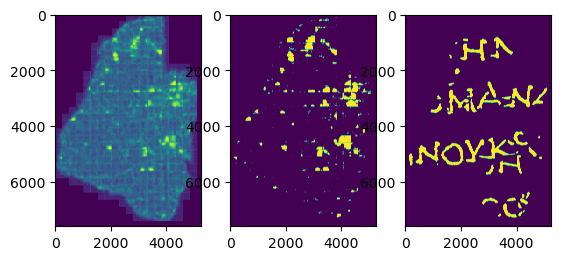

Epoch 1 - Save Best AUC: 0.8371. Model is saved.


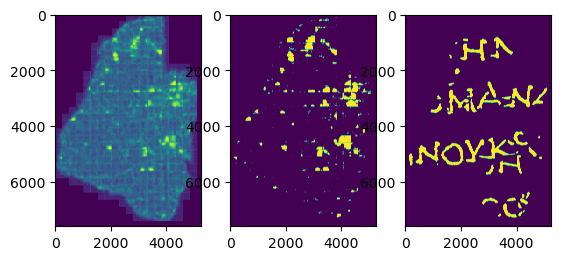

- epoch:2 -
Epoch: [2][0/130] Elapsed 0m 0s (remain 1m 51s) Loss: 0.5200(0.5200) 
Epoch: [2][129/130] Elapsed 0m 37s (remain 0m 0s) Loss: 0.5238(0.4672) 
EVAL: [0/27] Elapsed 0m 0s (remain 0m 6s) Loss: 0.2037(0.2037) 
EVAL: [26/27] Elapsed 0m 4s (remain 0m 0s) Loss: 0.2764(0.3347) 
	 th: 0.1, fbeta: 0.15462101209113774
	 th: 0.15, fbeta: 0.16589758998807777
	 th: 0.2, fbeta: 0.22833724473731906
	 th: 0.25, fbeta: 0.3483445807436253
	 th: 0.3, fbeta: 0.4412893225228139
	 th: 0.35, fbeta: 0.4757441424153575
	 th: 0.4, fbeta: 0.48152150867416527
	 th: 0.45, fbeta: 0.4725833093162161
	 th: 0.5, fbeta: 0.44845603875179046
	 th: 0.55, fbeta: 0.41846468674809484
	 th: 0.6, fbeta: 0.3735997754436658
	 th: 0.65, fbeta: 0.312327827134693
	 th: 0.7, fbeta: 0.242352632237499
	 th: 0.75, fbeta: 0.18195598813427086
	 th: 0.8, fbeta: 0.12458531215713482
	 th: 0.85, fbeta: 0.08211195320902547
	 th: 0.9, fbeta: 0.04556104496052
	 th: 0.95, fbeta: 0.011038837408557552
	 th: 1.0, fbeta: 0.0
	 epoch:2, av

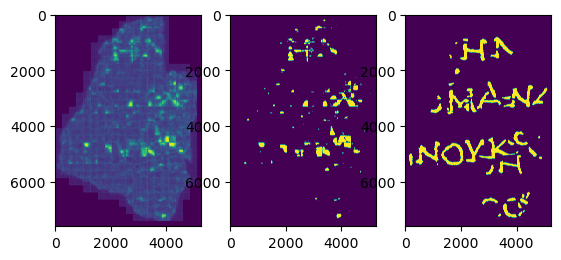

Epoch 2 - Save Best AUC: 0.8548. Model is saved.


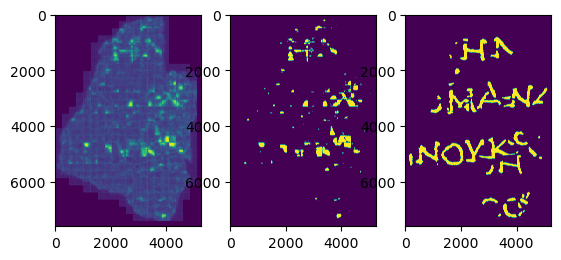

- epoch:3 -
Epoch: [3][0/130] Elapsed 0m 0s (remain 1m 48s) Loss: 0.3865(0.3865) 
Epoch: [3][129/130] Elapsed 0m 37s (remain 0m 0s) Loss: 0.2295(0.3883) 
EVAL: [0/27] Elapsed 0m 0s (remain 0m 6s) Loss: 0.1434(0.1434) 
EVAL: [26/27] Elapsed 0m 4s (remain 0m 0s) Loss: 0.2458(0.2953) 
	 th: 0.1, fbeta: 0.22733148078911333
	 th: 0.15, fbeta: 0.2981549929826584
	 th: 0.2, fbeta: 0.36673298287084777
	 th: 0.25, fbeta: 0.4143209443807128
	 th: 0.3, fbeta: 0.44340330028959674
	 th: 0.35, fbeta: 0.4669778716503662
	 th: 0.4, fbeta: 0.47417190053947916
	 th: 0.45, fbeta: 0.46086390675195366
	 th: 0.5, fbeta: 0.41680398512877925
	 th: 0.55, fbeta: 0.3595608657112436
	 th: 0.6, fbeta: 0.286335018373524
	 th: 0.65, fbeta: 0.19589031159121184
	 th: 0.7, fbeta: 0.11053158423854803
	 th: 0.75, fbeta: 0.04496244526085929
	 th: 0.8, fbeta: 0.015583033765933653
	 th: 0.85, fbeta: 0.0050025088761163575
	 th: 0.9, fbeta: 2.2070775660613813e-05
	 th: 0.95, fbeta: 0.0
	 th: 1.0, fbeta: 0.0
	 epoch:3, avg tra

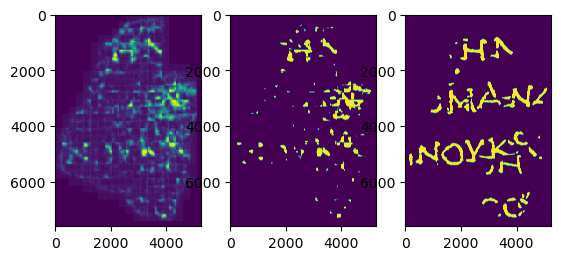

- epoch:5 -
Epoch: [5][0/130] Elapsed 0m 0s (remain 1m 54s) Loss: 0.2153(0.2153) 
Epoch: [5][129/130] Elapsed 0m 35s (remain 0m 0s) Loss: 0.4385(0.3371) 
EVAL: [0/27] Elapsed 0m 0s (remain 0m 6s) Loss: 0.1057(0.1057) 
EVAL: [26/27] Elapsed 0m 4s (remain 0m 0s) Loss: 0.2172(0.2709) 
	 th: 0.1, fbeta: 0.29263750467851213
	 th: 0.15, fbeta: 0.35295286573528434
	 th: 0.2, fbeta: 0.39820056329469083
	 th: 0.25, fbeta: 0.4338651898167046
	 th: 0.3, fbeta: 0.4634420815300195
	 th: 0.35, fbeta: 0.4864827821665731
	 th: 0.4, fbeta: 0.5020545948323559
	 th: 0.45, fbeta: 0.5126682691632191
	 th: 0.5, fbeta: 0.5204505115765571
	 th: 0.55, fbeta: 0.5245504500944181
	 th: 0.6, fbeta: 0.5253749623039964
	 th: 0.65, fbeta: 0.5209151326291316
	 th: 0.7, fbeta: 0.5132628075254029
	 th: 0.75, fbeta: 0.4969766257932913
	 th: 0.8, fbeta: 0.46283852731318587
	 th: 0.85, fbeta: 0.40702026730886853
	 th: 0.9, fbeta: 0.3044411938288432
	 th: 0.95, fbeta: 0.1286475106692645
	 th: 1.0, fbeta: 0.0
	 epoch:5, avg 

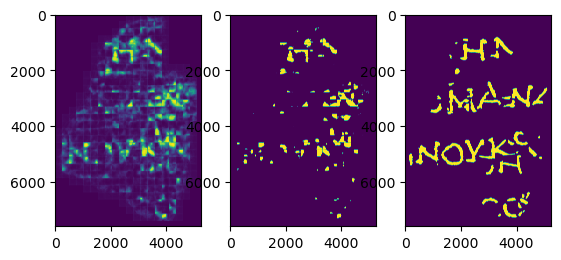

Epoch 5 - Save Best AUC: 0.8888. Model is saved.


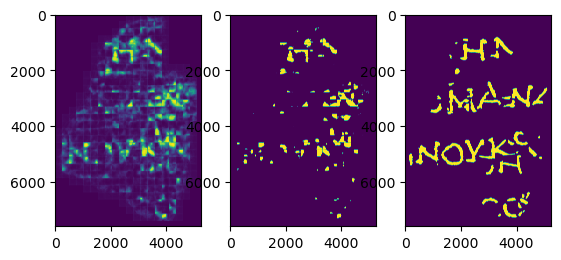

- epoch:6 -
Epoch: [6][0/130] Elapsed 0m 1s (remain 2m 11s) Loss: 0.3338(0.3338) 
Epoch: [6][129/130] Elapsed 0m 35s (remain 0m 0s) Loss: 0.2024(0.3122) 
EVAL: [0/27] Elapsed 0m 0s (remain 0m 5s) Loss: 0.1552(0.1552) 
EVAL: [26/27] Elapsed 0m 4s (remain 0m 0s) Loss: 0.2197(0.2793) 
	 th: 0.1, fbeta: 0.2616095210986399
	 th: 0.15, fbeta: 0.31180617745076983
	 th: 0.2, fbeta: 0.35475389761939724
	 th: 0.25, fbeta: 0.3899335524184658
	 th: 0.3, fbeta: 0.4230155932638796
	 th: 0.35, fbeta: 0.4528482535732264
	 th: 0.4, fbeta: 0.475150466799913
	 th: 0.45, fbeta: 0.49275788923227015
	 th: 0.5, fbeta: 0.5123474363030209
	 th: 0.55, fbeta: 0.5303200965588739
	 th: 0.6, fbeta: 0.5428358772774342
	 th: 0.65, fbeta: 0.5505123582937292
	 th: 0.7, fbeta: 0.5488021952762064
	 th: 0.75, fbeta: 0.5390346870096393
	 th: 0.8, fbeta: 0.5125237090797666
	 th: 0.85, fbeta: 0.46685967592368793
	 th: 0.9, fbeta: 0.3869388598367997
	 th: 0.95, fbeta: 0.27249738429840115
	 th: 1.0, fbeta: 0.0
	 epoch:6, avg t

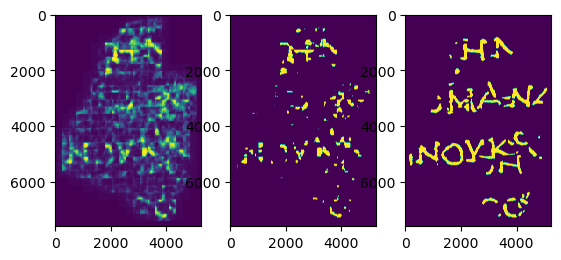

Epoch 6 - Save Best AUC: 0.8915. Model is saved.


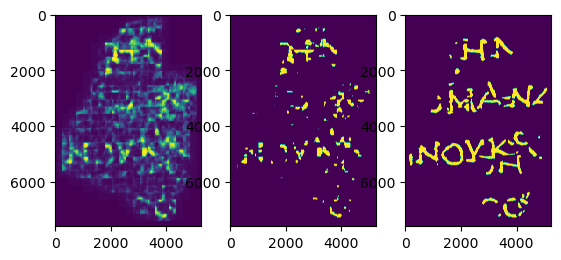

- epoch:7 -
Epoch: [7][0/130] Elapsed 0m 0s (remain 1m 57s) Loss: 0.3854(0.3854) 
Epoch: [7][129/130] Elapsed 0m 35s (remain 0m 0s) Loss: 0.2317(0.2970) 
EVAL: [0/27] Elapsed 0m 0s (remain 0m 6s) Loss: 0.0992(0.0992) 
EVAL: [26/27] Elapsed 0m 4s (remain 0m 0s) Loss: 0.2109(0.2675) 
	 th: 0.1, fbeta: 0.2619650981268487
	 th: 0.15, fbeta: 0.3167589265361306
	 th: 0.2, fbeta: 0.36619107561182995
	 th: 0.25, fbeta: 0.4140274591440312
	 th: 0.3, fbeta: 0.4569554931691504
	 th: 0.35, fbeta: 0.48676573933067613
	 th: 0.4, fbeta: 0.5113651073276384
	 th: 0.45, fbeta: 0.5309006428158717
	 th: 0.5, fbeta: 0.5440740280184058
	 th: 0.55, fbeta: 0.5481773173126183
	 th: 0.6, fbeta: 0.5391189409103011
	 th: 0.65, fbeta: 0.5130066604368648
	 th: 0.7, fbeta: 0.4687387663523319
	 th: 0.75, fbeta: 0.41433000580783363
	 th: 0.8, fbeta: 0.3379947947746456
	 th: 0.85, fbeta: 0.22813102215967365
	 th: 0.9, fbeta: 0.12789143386484642
	 th: 0.95, fbeta: 0.025861779959104752
	 th: 1.0, fbeta: 0.0
	 epoch:7, av

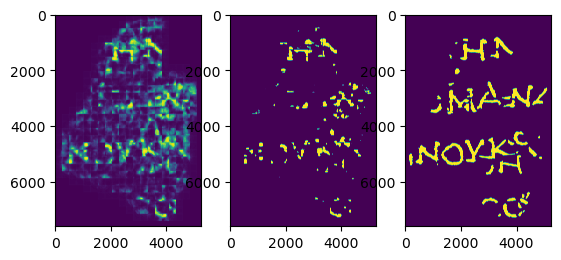

Epoch 8 - Save Best AUC: 0.8929. Model is saved.


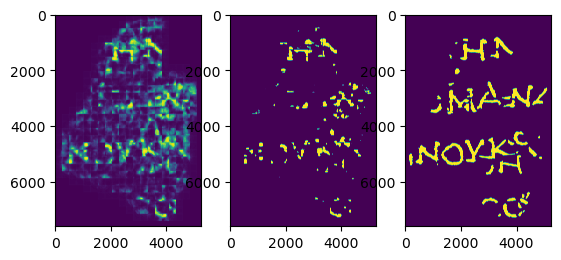

- epoch:9 -
Epoch: [9][0/130] Elapsed 0m 0s (remain 2m 3s) Loss: 0.2466(0.2466) 
Epoch: [9][129/130] Elapsed 0m 37s (remain 0m 0s) Loss: 0.2479(0.2627) 
EVAL: [0/27] Elapsed 0m 0s (remain 0m 6s) Loss: 0.1073(0.1073) 
EVAL: [26/27] Elapsed 0m 4s (remain 0m 0s) Loss: 0.2084(0.2673) 
	 th: 0.1, fbeta: 0.31853195907264337
	 th: 0.15, fbeta: 0.376503064912592
	 th: 0.2, fbeta: 0.4175003575460174
	 th: 0.25, fbeta: 0.45007704371017065
	 th: 0.3, fbeta: 0.4767583602753674
	 th: 0.35, fbeta: 0.49804406923139405
	 th: 0.4, fbeta: 0.5150948023297104
	 th: 0.45, fbeta: 0.5290473199715979
	 th: 0.5, fbeta: 0.540188189153756
	 th: 0.55, fbeta: 0.5475431299141269
	 th: 0.6, fbeta: 0.5532705800080084
	 th: 0.65, fbeta: 0.5566265916063492
	 th: 0.7, fbeta: 0.5557472576552459
	 th: 0.75, fbeta: 0.5439972499947859
	 th: 0.8, fbeta: 0.5226071854821361
	 th: 0.85, fbeta: 0.48615550392030726
	 th: 0.9, fbeta: 0.42453875855503703
	 th: 0.95, fbeta: 0.2864825717816817
	 th: 1.0, fbeta: 0.0
	 epoch:9, avg tra

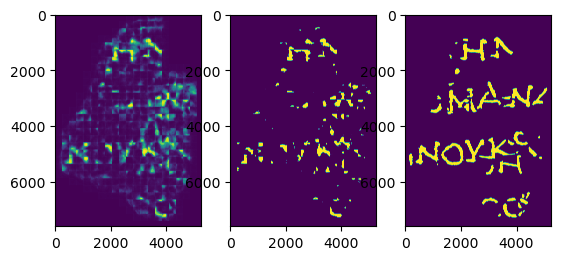

- epoch:15 -
Epoch: [15][0/130] Elapsed 0m 0s (remain 1m 46s) Loss: 0.1660(0.1660) 
Epoch: [15][129/130] Elapsed 0m 36s (remain 0m 0s) Loss: 0.6670(0.2501) 
EVAL: [0/27] Elapsed 0m 0s (remain 0m 6s) Loss: 0.1289(0.1289) 
EVAL: [26/27] Elapsed 0m 4s (remain 0m 0s) Loss: 0.2108(0.2887) 
	 th: 0.1, fbeta: 0.3029961002431226
	 th: 0.15, fbeta: 0.338043233732141
	 th: 0.2, fbeta: 0.3700613787282129
	 th: 0.25, fbeta: 0.40223873507013813
	 th: 0.3, fbeta: 0.43085548880139857
	 th: 0.35, fbeta: 0.4562642112822001
	 th: 0.4, fbeta: 0.47820598627476857
	 th: 0.45, fbeta: 0.49831575122559857
	 th: 0.5, fbeta: 0.5175368135335913
	 th: 0.55, fbeta: 0.5362475586006745
	 th: 0.6, fbeta: 0.5517344452325811
	 th: 0.65, fbeta: 0.5652969940421175
	 th: 0.7, fbeta: 0.5747660311449396
	 th: 0.75, fbeta: 0.5799877597595459
	 th: 0.8, fbeta: 0.58001721116609
	 th: 0.85, fbeta: 0.57253591473407
	 th: 0.9, fbeta: 0.5474015512468929
	 th: 0.95, fbeta: 0.49085746545242676
	 th: 1.0, fbeta: 0.0
	 epoch:15, avg t

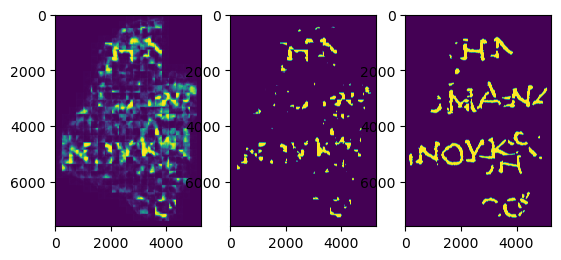

surface_list:  range(27, 37, 3)
initializing dataset...
/working/input/vesuvius-challenge-ink-detection/train/1/mask.png
/working/input/vesuvius-challenge-ink-detection/train/2/mask.png
reading surface volume...
 reading idx : 4/4  => read surface volume done. [1]
 reading idx : 4/4  => read surface volume done. [2]
split grid done.
initializing dataset done.
initializing dataset...
/working/input/vesuvius-challenge-ink-detection/train/3/mask.png
reading surface volume...
 reading idx : 4/4  => read surface volume done. [3]
split grid done.
initializing dataset done.
- epoch:1 -
Epoch: [1][0/130] Elapsed 0m 0s (remain 2m 5s) Loss: 0.2755(0.2755) 
Epoch: [1][129/130] Elapsed 0m 36s (remain 0m 0s) Loss: 1.0193(0.2806) 
EVAL: [0/27] Elapsed 0m 0s (remain 0m 6s) Loss: 0.1113(0.1113) 
EVAL: [26/27] Elapsed 0m 4s (remain 0m 0s) Loss: 0.1662(0.2853) 
	 th: 0.1, fbeta: 0.331943417634178
	 th: 0.15, fbeta: 0.3721964721227224
	 th: 0.2, fbeta: 0.4019997212394
	 th: 0.25, fbeta: 0.423378261450514

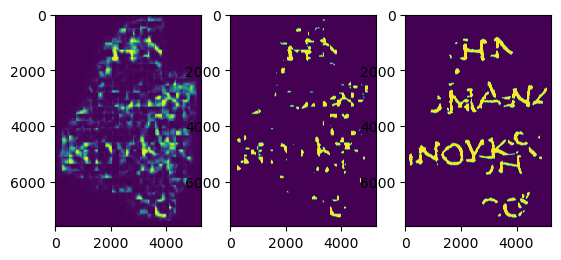

Epoch 1 - Save Best AUC: 0.8799. Model is saved.


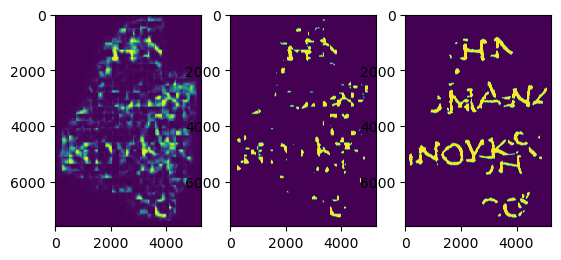

- epoch:2 -
Epoch: [2][0/130] Elapsed 0m 1s (remain 2m 9s) Loss: 0.2982(0.2982) 
Epoch: [2][129/130] Elapsed 0m 36s (remain 0m 0s) Loss: 0.2376(0.3145) 
EVAL: [0/27] Elapsed 0m 0s (remain 0m 6s) Loss: 0.0863(0.0863) 
EVAL: [26/27] Elapsed 0m 4s (remain 0m 0s) Loss: 0.1759(0.2805) 
	 th: 0.1, fbeta: 0.26750579537009905
	 th: 0.15, fbeta: 0.3136110460427425
	 th: 0.2, fbeta: 0.3526187176776914
	 th: 0.25, fbeta: 0.38546404719912947
	 th: 0.3, fbeta: 0.4132744800035374
	 th: 0.35, fbeta: 0.439328528882682
	 th: 0.4, fbeta: 0.4612503576869096
	 th: 0.45, fbeta: 0.47711899844338107
	 th: 0.5, fbeta: 0.48563980332960227
	 th: 0.55, fbeta: 0.48802385789411956
	 th: 0.6, fbeta: 0.48138113347712935
	 th: 0.65, fbeta: 0.46588947676635367
	 th: 0.7, fbeta: 0.4416848161304158
	 th: 0.75, fbeta: 0.40115467729950416
	 th: 0.8, fbeta: 0.3391854754048832
	 th: 0.85, fbeta: 0.25838245339833904
	 th: 0.9, fbeta: 0.15981134643294637
	 th: 0.95, fbeta: 0.05484693467666159
	 th: 1.0, fbeta: 0.0
	 epoch:2, 

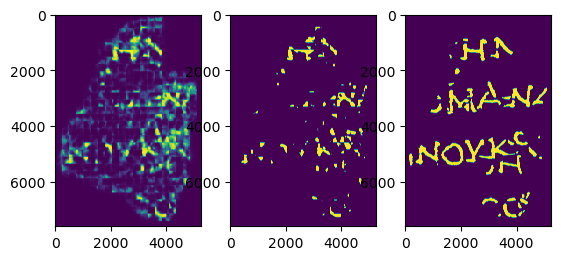

Epoch 3 - Save Best AUC: 0.8830. Model is saved.


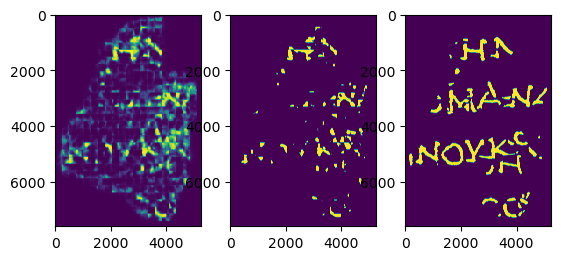

- epoch:4 -
Epoch: [4][0/130] Elapsed 0m 0s (remain 2m 3s) Loss: 0.1682(0.1682) 
Epoch: [4][129/130] Elapsed 0m 35s (remain 0m 0s) Loss: 0.2360(0.2760) 
EVAL: [0/27] Elapsed 0m 0s (remain 0m 6s) Loss: 0.0862(0.0862) 
EVAL: [26/27] Elapsed 0m 4s (remain 0m 0s) Loss: 0.2117(0.2802) 
	 th: 0.1, fbeta: 0.2943384827984788
	 th: 0.15, fbeta: 0.34311342937258477
	 th: 0.2, fbeta: 0.3811075218608089
	 th: 0.25, fbeta: 0.4125405504870735
	 th: 0.3, fbeta: 0.43859314189918935
	 th: 0.35, fbeta: 0.46167168006444925
	 th: 0.4, fbeta: 0.4838779146957672
	 th: 0.45, fbeta: 0.5036371053285441
	 th: 0.5, fbeta: 0.516658913427935
	 th: 0.55, fbeta: 0.5248365187808751
	 th: 0.6, fbeta: 0.5300136972443557
	 th: 0.65, fbeta: 0.5250078973708389
	 th: 0.7, fbeta: 0.5070041870703025
	 th: 0.75, fbeta: 0.47334848269289764
	 th: 0.8, fbeta: 0.42452487946684936
	 th: 0.85, fbeta: 0.3612746496648992
	 th: 0.9, fbeta: 0.2777420313150507
	 th: 0.95, fbeta: 0.16185132146091244
	 th: 1.0, fbeta: 0.0
	 epoch:4, avg t

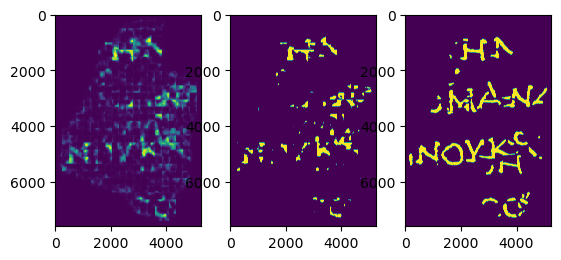

Epoch 5 - Save Best AUC: 0.8862. Model is saved.


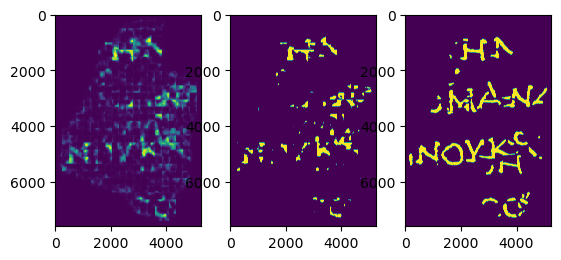

- epoch:6 -
Epoch: [6][0/130] Elapsed 0m 0s (remain 2m 0s) Loss: 0.2767(0.2767) 
Epoch: [6][129/130] Elapsed 0m 35s (remain 0m 0s) Loss: 0.1924(0.2617) 
EVAL: [0/27] Elapsed 0m 0s (remain 0m 6s) Loss: 0.1521(0.1521) 
EVAL: [26/27] Elapsed 0m 4s (remain 0m 0s) Loss: 0.1832(0.3323) 
	 th: 0.1, fbeta: 0.2603210247047547
	 th: 0.15, fbeta: 0.28557761606548987
	 th: 0.2, fbeta: 0.3083107384521665
	 th: 0.25, fbeta: 0.3271449543215557
	 th: 0.3, fbeta: 0.34533486335590396
	 th: 0.35, fbeta: 0.36284187466159495
	 th: 0.4, fbeta: 0.381177755754583
	 th: 0.45, fbeta: 0.39973159180571216
	 th: 0.5, fbeta: 0.41760275413567555
	 th: 0.55, fbeta: 0.43548782224537086
	 th: 0.6, fbeta: 0.45345609575535323
	 th: 0.65, fbeta: 0.47421787220513
	 th: 0.7, fbeta: 0.4958176062308021
	 th: 0.75, fbeta: 0.5123662274809047
	 th: 0.8, fbeta: 0.5191711580667487
	 th: 0.85, fbeta: 0.5097683574549297
	 th: 0.9, fbeta: 0.46817422889469734
	 th: 0.95, fbeta: 0.32478020363864335
	 th: 1.0, fbeta: 0.0
	 epoch:6, avg 

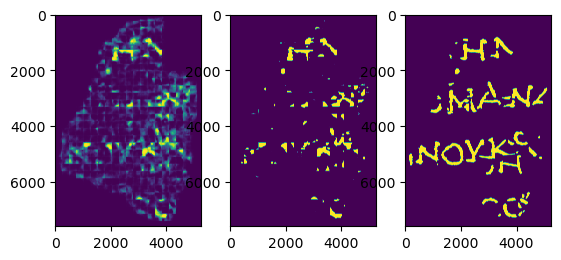

- epoch:9 -
Epoch: [9][0/130] Elapsed 0m 0s (remain 2m 4s) Loss: 0.2189(0.2189) 
Epoch: [9][129/130] Elapsed 0m 35s (remain 0m 0s) Loss: 0.1797(0.2367) 
EVAL: [0/27] Elapsed 0m 0s (remain 0m 6s) Loss: 0.1053(0.1053) 
EVAL: [26/27] Elapsed 0m 4s (remain 0m 0s) Loss: 0.2084(0.2872) 
	 th: 0.1, fbeta: 0.3080257828673501
	 th: 0.15, fbeta: 0.3455069219981971
	 th: 0.2, fbeta: 0.3744415498602885
	 th: 0.25, fbeta: 0.3981018868744801
	 th: 0.3, fbeta: 0.42081903528863773
	 th: 0.35, fbeta: 0.44389866971991704
	 th: 0.4, fbeta: 0.46340153140557133
	 th: 0.45, fbeta: 0.4816357301691699
	 th: 0.5, fbeta: 0.5007290610461381
	 th: 0.55, fbeta: 0.5208095363491391
	 th: 0.6, fbeta: 0.5418872237355127
	 th: 0.65, fbeta: 0.5567626418189023
	 th: 0.7, fbeta: 0.5663917005409085
	 th: 0.75, fbeta: 0.571185035487347
	 th: 0.8, fbeta: 0.564313559775818
	 th: 0.85, fbeta: 0.5425460213308262
	 th: 0.9, fbeta: 0.49374037690448397
	 th: 0.95, fbeta: 0.3955101992976106
	 th: 1.0, fbeta: 0.0
	 epoch:9, avg trai

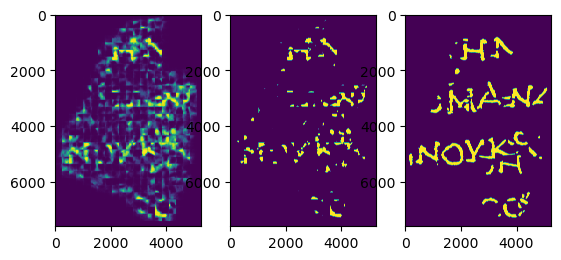

- epoch:10 -
Epoch: [10][0/130] Elapsed 0m 0s (remain 1m 53s) Loss: 0.2219(0.2219) 
Epoch: [10][129/130] Elapsed 0m 35s (remain 0m 0s) Loss: 0.3364(0.2109) 
EVAL: [0/27] Elapsed 0m 0s (remain 0m 6s) Loss: 0.0631(0.0631) 
EVAL: [26/27] Elapsed 0m 4s (remain 0m 0s) Loss: 0.1960(0.3042) 
	 th: 0.1, fbeta: 0.3855233540877569
	 th: 0.15, fbeta: 0.4237791974435821
	 th: 0.2, fbeta: 0.4496357399278301
	 th: 0.25, fbeta: 0.46721432405382535
	 th: 0.3, fbeta: 0.48247758601175433
	 th: 0.35, fbeta: 0.49633594021669836
	 th: 0.4, fbeta: 0.5059640101179891
	 th: 0.45, fbeta: 0.5139723022997437
	 th: 0.5, fbeta: 0.5198243569219351
	 th: 0.55, fbeta: 0.5235000206958152
	 th: 0.6, fbeta: 0.5248544020333461
	 th: 0.65, fbeta: 0.5223212773558066
	 th: 0.7, fbeta: 0.5174275048478084
	 th: 0.75, fbeta: 0.5076487477091449
	 th: 0.8, fbeta: 0.493283074401112
	 th: 0.85, fbeta: 0.473869160061154
	 th: 0.9, fbeta: 0.4421132755121545
	 th: 0.95, fbeta: 0.3771413719217541
	 th: 1.0, fbeta: 0.0
	 epoch:10, avg 

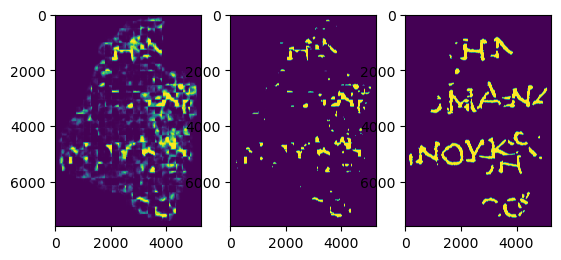

Epoch 1 - Save Best AUC: 0.8754. Model is saved.


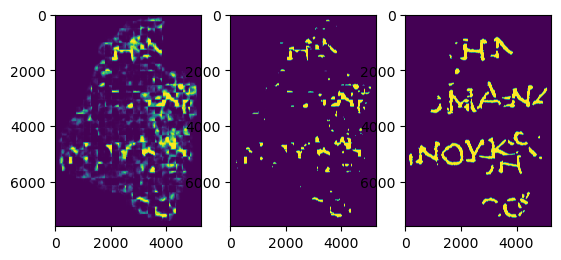

- epoch:2 -
Epoch: [2][0/130] Elapsed 0m 0s (remain 2m 6s) Loss: 0.1365(0.1365) 
Epoch: [2][129/130] Elapsed 0m 36s (remain 0m 0s) Loss: 0.4177(0.2212) 
EVAL: [0/27] Elapsed 0m 0s (remain 0m 6s) Loss: 0.1057(0.1057) 
EVAL: [26/27] Elapsed 0m 4s (remain 0m 0s) Loss: 0.1918(0.3215) 
	 th: 0.1, fbeta: 0.3489393158307291
	 th: 0.15, fbeta: 0.3838113910500006
	 th: 0.2, fbeta: 0.40711185759345153
	 th: 0.25, fbeta: 0.4263036631197508
	 th: 0.3, fbeta: 0.4428668187454811
	 th: 0.35, fbeta: 0.459727345596999
	 th: 0.4, fbeta: 0.47434628240713006
	 th: 0.45, fbeta: 0.48643970157077515
	 th: 0.5, fbeta: 0.49659310151612573
	 th: 0.55, fbeta: 0.5072087412990931
	 th: 0.6, fbeta: 0.5166232168226312
	 th: 0.65, fbeta: 0.5251484525163655
	 th: 0.7, fbeta: 0.5337141597441228
	 th: 0.75, fbeta: 0.5376116217254452
	 th: 0.8, fbeta: 0.5367510115134204
	 th: 0.85, fbeta: 0.532917086441805
	 th: 0.9, fbeta: 0.5205772514229586
	 th: 0.95, fbeta: 0.4840880095896859
	 th: 1.0, fbeta: 0.017502959646864675
	 

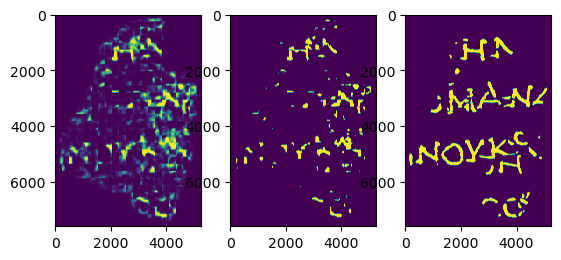

- epoch:3 -
Epoch: [3][0/130] Elapsed 0m 0s (remain 1m 51s) Loss: 0.1511(0.1511) 
Epoch: [3][129/130] Elapsed 0m 36s (remain 0m 0s) Loss: 0.3353(0.2174) 
EVAL: [0/27] Elapsed 0m 0s (remain 0m 6s) Loss: 0.1183(0.1183) 
EVAL: [26/27] Elapsed 0m 4s (remain 0m 0s) Loss: 0.1964(0.3147) 
	 th: 0.1, fbeta: 0.3063655120730865
	 th: 0.15, fbeta: 0.34282882444310464
	 th: 0.2, fbeta: 0.37214623631797333
	 th: 0.25, fbeta: 0.396220459905004
	 th: 0.3, fbeta: 0.41320824365338954
	 th: 0.35, fbeta: 0.42876881199257333
	 th: 0.4, fbeta: 0.4432063322968546
	 th: 0.45, fbeta: 0.4572598046669701
	 th: 0.5, fbeta: 0.46908995015528765
	 th: 0.55, fbeta: 0.4818293705532871
	 th: 0.6, fbeta: 0.4947234857775797
	 th: 0.65, fbeta: 0.5050762168344715
	 th: 0.7, fbeta: 0.5138248712764466
	 th: 0.75, fbeta: 0.5181502117329024
	 th: 0.8, fbeta: 0.5219144822979999
	 th: 0.85, fbeta: 0.5181938431414832
	 th: 0.9, fbeta: 0.5002451409835357
	 th: 0.95, fbeta: 0.4362058686489146
	 th: 1.0, fbeta: 0.005871596517995511

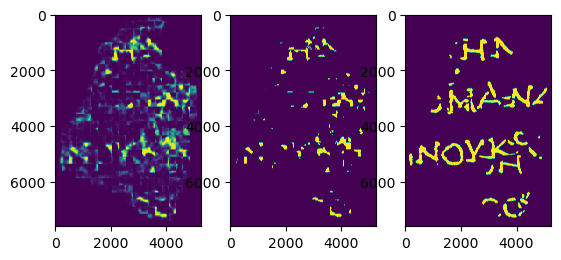

- epoch:5 -
Epoch: [5][0/130] Elapsed 0m 0s (remain 1m 56s) Loss: 0.1839(0.1839) 
Epoch: [5][129/130] Elapsed 0m 36s (remain 0m 0s) Loss: 0.2051(0.1948) 
EVAL: [0/27] Elapsed 0m 0s (remain 0m 6s) Loss: 0.0466(0.0466) 
EVAL: [26/27] Elapsed 0m 4s (remain 0m 0s) Loss: 0.2079(0.3334) 
	 th: 0.1, fbeta: 0.31078622270052364
	 th: 0.15, fbeta: 0.3495538777547706
	 th: 0.2, fbeta: 0.37443728680795507
	 th: 0.25, fbeta: 0.3931774784041068
	 th: 0.3, fbeta: 0.4093022005512436
	 th: 0.35, fbeta: 0.42299992061761754
	 th: 0.4, fbeta: 0.437818364453913
	 th: 0.45, fbeta: 0.45250074534563633
	 th: 0.5, fbeta: 0.46619234655407543
	 th: 0.55, fbeta: 0.4782159394913458
	 th: 0.6, fbeta: 0.49068855848637477
	 th: 0.65, fbeta: 0.5025393080263736
	 th: 0.7, fbeta: 0.5131802866826023
	 th: 0.75, fbeta: 0.523089290456433
	 th: 0.8, fbeta: 0.5338766417413509
	 th: 0.85, fbeta: 0.5410331073082558
	 th: 0.9, fbeta: 0.538349213312997
	 th: 0.95, fbeta: 0.513599175677521
	 th: 1.0, fbeta: 0.04083371966735978
	 

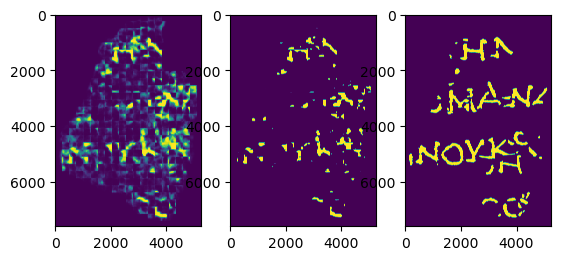

- epoch:6 -
Epoch: [6][0/130] Elapsed 0m 0s (remain 1m 59s) Loss: 0.1994(0.1994) 
Epoch: [6][129/130] Elapsed 0m 35s (remain 0m 0s) Loss: 0.4126(0.1969) 
EVAL: [0/27] Elapsed 0m 0s (remain 0m 6s) Loss: 0.0619(0.0619) 
EVAL: [26/27] Elapsed 0m 4s (remain 0m 0s) Loss: 0.1848(0.3094) 
	 th: 0.1, fbeta: 0.38688379179795424
	 th: 0.15, fbeta: 0.41188814075158314
	 th: 0.2, fbeta: 0.4290311598815421
	 th: 0.25, fbeta: 0.4441352813683385
	 th: 0.3, fbeta: 0.45793508337352246
	 th: 0.35, fbeta: 0.47092727967518655
	 th: 0.4, fbeta: 0.4837817982015793
	 th: 0.45, fbeta: 0.4950434323846526
	 th: 0.5, fbeta: 0.5035492104154912
	 th: 0.55, fbeta: 0.5102436274488409
	 th: 0.6, fbeta: 0.5150256308717789
	 th: 0.65, fbeta: 0.5177861358026254
	 th: 0.7, fbeta: 0.518514599515081
	 th: 0.75, fbeta: 0.5162903227898425
	 th: 0.8, fbeta: 0.5089657502826089
	 th: 0.85, fbeta: 0.49476634946359227
	 th: 0.9, fbeta: 0.4613894452777941
	 th: 0.95, fbeta: 0.3686651535923952
	 th: 1.0, fbeta: 0.0
	 epoch:6, avg t

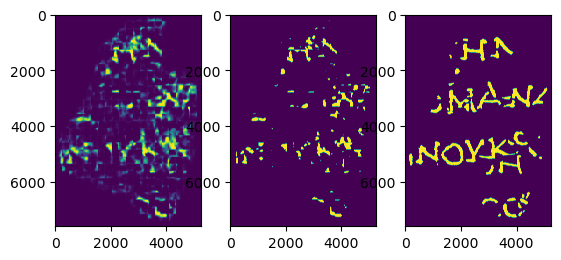

- epoch:7 -
Epoch: [7][0/130] Elapsed 0m 0s (remain 2m 5s) Loss: 0.2373(0.2373) 
Epoch: [7][129/130] Elapsed 0m 35s (remain 0m 0s) Loss: 0.4171(0.2032) 
EVAL: [0/27] Elapsed 0m 0s (remain 0m 6s) Loss: 0.0851(0.0851) 
EVAL: [26/27] Elapsed 0m 4s (remain 0m 0s) Loss: 0.2016(0.2992) 
	 th: 0.1, fbeta: 0.31604603496863715
	 th: 0.15, fbeta: 0.35022805659356854
	 th: 0.2, fbeta: 0.37834462042425243
	 th: 0.25, fbeta: 0.40322540628304937
	 th: 0.3, fbeta: 0.42487494542594395
	 th: 0.35, fbeta: 0.44271888030719164
	 th: 0.4, fbeta: 0.4584940390227661
	 th: 0.45, fbeta: 0.47351882104638626
	 th: 0.5, fbeta: 0.4869032430389065
	 th: 0.55, fbeta: 0.49929546156585386
	 th: 0.6, fbeta: 0.5109195146068938
	 th: 0.65, fbeta: 0.5204933136520387
	 th: 0.7, fbeta: 0.5254504547464707
	 th: 0.75, fbeta: 0.5213708336695438
	 th: 0.8, fbeta: 0.5068259617378025
	 th: 0.85, fbeta: 0.4774281138869815
	 th: 0.9, fbeta: 0.4192569450424437
	 th: 0.95, fbeta: 0.31179738094388837
	 th: 1.0, fbeta: 0.0
	 epoch:7, a

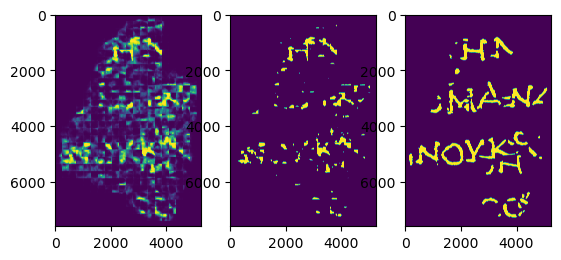

Epoch 11 - Save Best AUC: 0.8969. Model is saved.


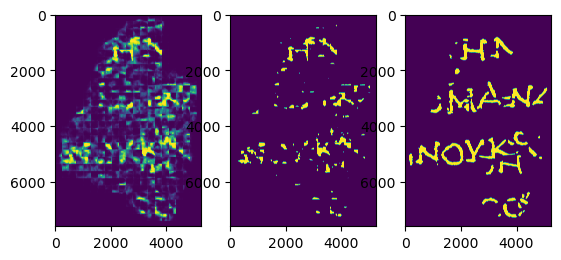

- epoch:12 -
Epoch: [12][0/130] Elapsed 0m 0s (remain 2m 1s) Loss: 0.1278(0.1278) 
Epoch: [12][129/130] Elapsed 0m 35s (remain 0m 0s) Loss: 0.4216(0.1980) 
EVAL: [0/27] Elapsed 0m 0s (remain 0m 6s) Loss: 0.0441(0.0441) 
EVAL: [26/27] Elapsed 0m 4s (remain 0m 0s) Loss: 0.2324(0.2882) 
	 th: 0.1, fbeta: 0.41721564380838383
	 th: 0.15, fbeta: 0.4619171118903548
	 th: 0.2, fbeta: 0.49150032172717895
	 th: 0.25, fbeta: 0.515198146044841
	 th: 0.3, fbeta: 0.5360730615536689
	 th: 0.35, fbeta: 0.5503103168990854
	 th: 0.4, fbeta: 0.5600184880349476
	 th: 0.45, fbeta: 0.5640785397472453
	 th: 0.5, fbeta: 0.5620173269605202
	 th: 0.55, fbeta: 0.5527994974282173
	 th: 0.6, fbeta: 0.5386797637951919
	 th: 0.65, fbeta: 0.5179097564499267
	 th: 0.7, fbeta: 0.4923130892468392
	 th: 0.75, fbeta: 0.4590745158717769
	 th: 0.8, fbeta: 0.41868763514170226
	 th: 0.85, fbeta: 0.37255168299257185
	 th: 0.9, fbeta: 0.3099863961739861
	 th: 0.95, fbeta: 0.237799111219925
	 th: 1.0, fbeta: 0.0
	 epoch:12, avg 

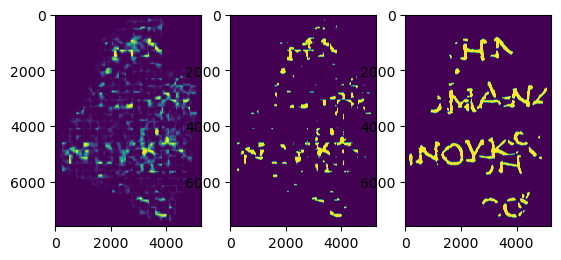

- epoch:13 -
Epoch: [13][0/130] Elapsed 0m 0s (remain 1m 48s) Loss: 0.1340(0.1340) 
Epoch: [13][129/130] Elapsed 0m 35s (remain 0m 0s) Loss: 0.1863(0.1931) 
EVAL: [0/27] Elapsed 0m 0s (remain 0m 6s) Loss: 0.1445(0.1445) 
EVAL: [26/27] Elapsed 0m 4s (remain 0m 0s) Loss: 0.2147(0.2866) 
	 th: 0.1, fbeta: 0.3490364198615823
	 th: 0.15, fbeta: 0.3872372408402689
	 th: 0.2, fbeta: 0.4167951109749883
	 th: 0.25, fbeta: 0.442603394335256
	 th: 0.3, fbeta: 0.46358025541832365
	 th: 0.35, fbeta: 0.47937584874182104
	 th: 0.4, fbeta: 0.49172088908489053
	 th: 0.45, fbeta: 0.5009332245185983
	 th: 0.5, fbeta: 0.5105913002798707
	 th: 0.55, fbeta: 0.5173285751687204
	 th: 0.6, fbeta: 0.5229027328042677
	 th: 0.65, fbeta: 0.5268767816413662
	 th: 0.7, fbeta: 0.5268209516531033
	 th: 0.75, fbeta: 0.5218137024664256
	 th: 0.8, fbeta: 0.5084943477350882
	 th: 0.85, fbeta: 0.48283585493657344
	 th: 0.9, fbeta: 0.4341552906657966
	 th: 0.95, fbeta: 0.3444481446712701
	 th: 1.0, fbeta: 0.0
	 epoch:13, av

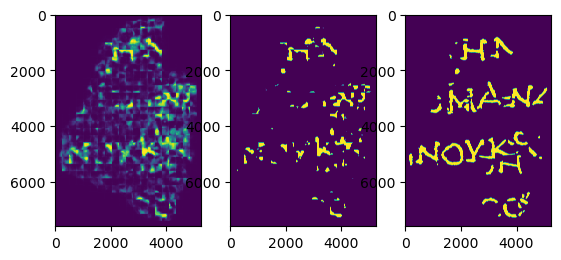

[fold0] slice ave score:0.5769(th=0.650000), auc=0.895672
[fold0] BEST Epoch 12 - Save Best Score:0.5641. Best loss:0.2882
[fold0] BEST AUC Epoch 11 - Save Best Score:0.8969. Best loss:0.2940
-- fold1 training start --
surface_list:  range(26, 36, 3)
initializing dataset...
/working/input/vesuvius-challenge-ink-detection/train/1/mask.png
/working/input/vesuvius-challenge-ink-detection/train/3/mask.png
reading surface volume...
 reading idx : 4/4  => read surface volume done. [1]
 reading idx : 4/4  => read surface volume done. [3]
split grid done.
initializing dataset done.
initializing dataset...
/working/input/vesuvius-challenge-ink-detection/train/2/mask.png
reading surface volume...
 reading idx : 4/4  => read surface volume done. [2]
split grid done.
initializing dataset done.
- epoch:1 -
Epoch: [1][0/58] Elapsed 0m 0s (remain 0m 46s) Loss: 0.6761(0.6761) 
Epoch: [1][57/58] Elapsed 0m 17s (remain 0m 0s) Loss: 0.6176(0.5956) 
EVAL: [0/99] Elapsed 0m 0s (remain 0m 25s) Loss: 0.2567(

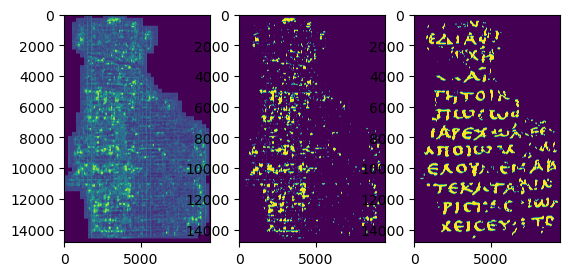

Epoch 1 - Save Best AUC: 0.7760. Model is saved.


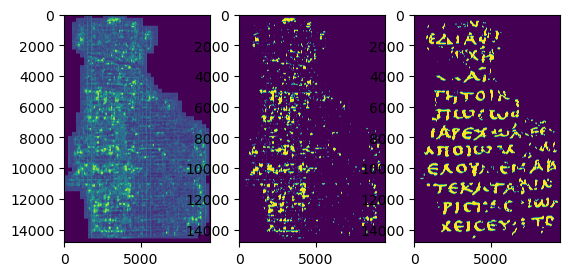

- epoch:2 -
Epoch: [2][0/58] Elapsed 0m 0s (remain 0m 48s) Loss: 0.5690(0.5690) 
Epoch: [2][57/58] Elapsed 0m 16s (remain 0m 0s) Loss: 0.5798(0.5283) 
EVAL: [0/99] Elapsed 0m 0s (remain 0m 25s) Loss: 0.3100(0.3100) 
EVAL: [98/99] Elapsed 0m 16s (remain 0m 0s) Loss: 0.3005(0.6498) 
	 th: 0.1, fbeta: 0.19682022738223717
	 th: 0.15, fbeta: 0.19691679709230409
	 th: 0.2, fbeta: 0.20038163847530305
	 th: 0.25, fbeta: 0.23176913725250867
	 th: 0.3, fbeta: 0.2977609645143422
	 th: 0.35, fbeta: 0.3345913460021004
	 th: 0.4, fbeta: 0.3461242135774815
	 th: 0.45, fbeta: 0.34014340217210787
	 th: 0.5, fbeta: 0.3300149101257637
	 th: 0.55, fbeta: 0.31881050907387687
	 th: 0.6, fbeta: 0.30740114777153704
	 th: 0.65, fbeta: 0.297050205918777
	 th: 0.7, fbeta: 0.2874811311774907
	 th: 0.75, fbeta: 0.2783609426797842
	 th: 0.8, fbeta: 0.2690147180506926
	 th: 0.85, fbeta: 0.2584360702386067
	 th: 0.9, fbeta: 0.24724332835506058
	 th: 0.95, fbeta: 0.2326756862319922
	 th: 1.0, fbeta: 0.0481637026411929

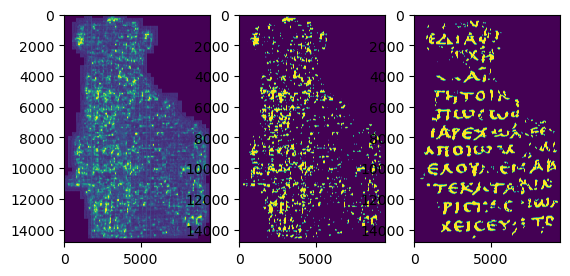

Epoch 4 - Save Best AUC: 0.8029. Model is saved.


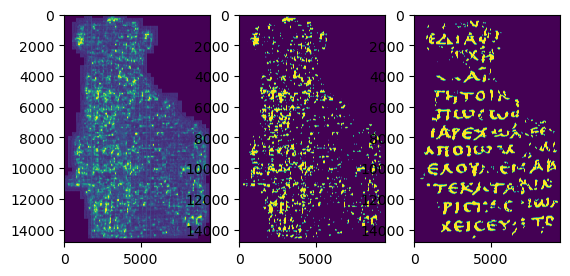

- epoch:5 -
Epoch: [5][0/58] Elapsed 0m 0s (remain 0m 56s) Loss: 0.4083(0.4083) 
Epoch: [5][57/58] Elapsed 0m 17s (remain 0m 0s) Loss: 0.3638(0.3528) 
EVAL: [0/99] Elapsed 0m 0s (remain 0m 26s) Loss: 0.1153(0.1153) 
EVAL: [98/99] Elapsed 0m 17s (remain 0m 0s) Loss: 0.1264(0.4106) 
	 th: 0.1, fbeta: 0.21412809232871172
	 th: 0.15, fbeta: 0.30274435330340504
	 th: 0.2, fbeta: 0.3549466710458131
	 th: 0.25, fbeta: 0.37319906956410753
	 th: 0.3, fbeta: 0.3558078276048611
	 th: 0.35, fbeta: 0.32539306052291783
	 th: 0.4, fbeta: 0.28609100800542453
	 th: 0.45, fbeta: 0.24649422958467632
	 th: 0.5, fbeta: 0.20975687549807348
	 th: 0.55, fbeta: 0.17677542679044356
	 th: 0.6, fbeta: 0.14623412840426597
	 th: 0.65, fbeta: 0.11717945949168725
	 th: 0.7, fbeta: 0.09216172162972108
	 th: 0.75, fbeta: 0.07099779837110723
	 th: 0.8, fbeta: 0.05209877096312153
	 th: 0.85, fbeta: 0.03346885247404223
	 th: 0.9, fbeta: 0.01965405506936822
	 th: 0.95, fbeta: 0.008496779658232942
	 th: 1.0, fbeta: 0.0
	 ep

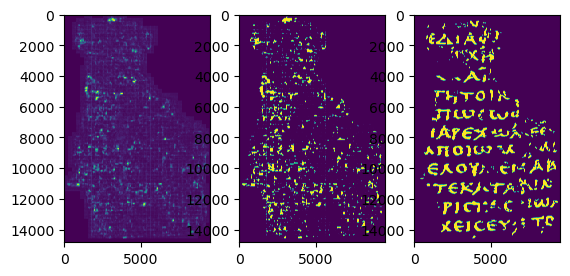

Epoch 1 - Save Best AUC: 0.7620. Model is saved.


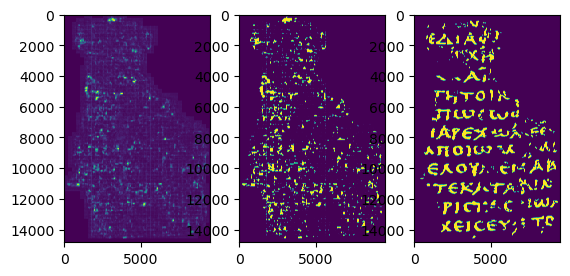

- epoch:2 -
Epoch: [2][0/58] Elapsed 0m 0s (remain 0m 53s) Loss: 0.2415(0.2415) 
Epoch: [2][57/58] Elapsed 0m 16s (remain 0m 0s) Loss: 0.2915(0.2241) 
EVAL: [0/99] Elapsed 0m 0s (remain 0m 28s) Loss: 0.0540(0.0540) 
EVAL: [98/99] Elapsed 0m 17s (remain 0m 0s) Loss: 0.0477(0.5136) 
	 th: 0.1, fbeta: 0.323148843246623
	 th: 0.15, fbeta: 0.3054125864873672
	 th: 0.2, fbeta: 0.27607421761833273
	 th: 0.25, fbeta: 0.24840906613976224
	 th: 0.3, fbeta: 0.22281476766124134
	 th: 0.35, fbeta: 0.19806297703183567
	 th: 0.4, fbeta: 0.1761187903695511
	 th: 0.45, fbeta: 0.15747796388602459
	 th: 0.5, fbeta: 0.14091859354411962
	 th: 0.55, fbeta: 0.12544373105645656
	 th: 0.6, fbeta: 0.11061129425083059
	 th: 0.65, fbeta: 0.09653709695903785
	 th: 0.7, fbeta: 0.08358412816675592
	 th: 0.75, fbeta: 0.07210993283843532
	 th: 0.8, fbeta: 0.061432337205101537
	 th: 0.85, fbeta: 0.050945268463317095
	 th: 0.9, fbeta: 0.03942112931539732
	 th: 0.95, fbeta: 0.028410607610605154
	 th: 1.0, fbeta: 0.000203

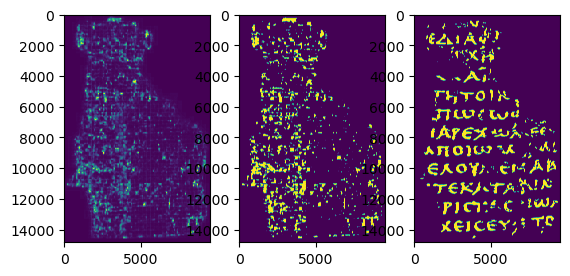

Epoch 4 - Save Best AUC: 0.7825. Model is saved.


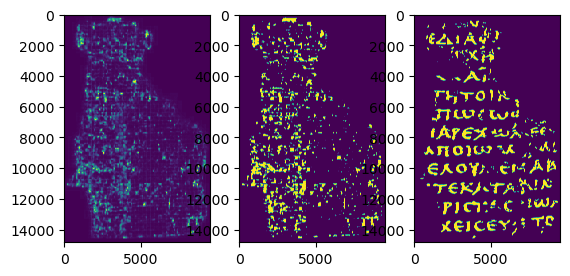

- epoch:5 -
Epoch: [5][0/58] Elapsed 0m 0s (remain 0m 52s) Loss: 0.1749(0.1749) 
Epoch: [5][57/58] Elapsed 0m 16s (remain 0m 0s) Loss: 0.1490(0.2147) 
EVAL: [0/99] Elapsed 0m 0s (remain 0m 26s) Loss: 0.0230(0.0230) 
EVAL: [98/99] Elapsed 0m 17s (remain 0m 0s) Loss: 0.0247(0.5342) 
	 th: 0.1, fbeta: 0.33854243461464845
	 th: 0.15, fbeta: 0.3237731231225653
	 th: 0.2, fbeta: 0.2999183981187745
	 th: 0.25, fbeta: 0.27431687136205724
	 th: 0.3, fbeta: 0.24902932977425388
	 th: 0.35, fbeta: 0.22530993224640927
	 th: 0.4, fbeta: 0.20223478221869481
	 th: 0.45, fbeta: 0.17889212117451847
	 th: 0.5, fbeta: 0.15677886178086584
	 th: 0.55, fbeta: 0.13549116011840945
	 th: 0.6, fbeta: 0.11599227380008612
	 th: 0.65, fbeta: 0.09724882316608058
	 th: 0.7, fbeta: 0.08044121471121916
	 th: 0.75, fbeta: 0.06423724617739075
	 th: 0.8, fbeta: 0.04746999372023718
	 th: 0.85, fbeta: 0.03128569144781807
	 th: 0.9, fbeta: 0.014436429200774393
	 th: 0.95, fbeta: 0.0029293594933795697
	 th: 1.0, fbeta: 0.0
	 

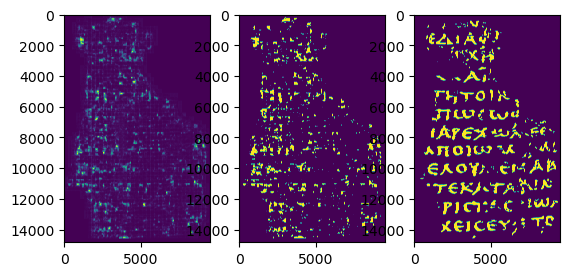

Epoch 6 - Save Best AUC: 0.7908. Model is saved.


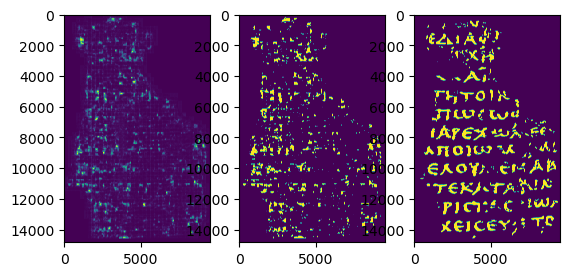

- epoch:7 -
Epoch: [7][0/58] Elapsed 0m 1s (remain 1m 0s) Loss: 0.2321(0.2321) 
Epoch: [7][57/58] Elapsed 0m 16s (remain 0m 0s) Loss: 0.1979(0.2016) 
EVAL: [0/99] Elapsed 0m 0s (remain 0m 26s) Loss: 0.0111(0.0111) 
EVAL: [98/99] Elapsed 0m 17s (remain 0m 0s) Loss: 0.0182(0.5779) 
	 th: 0.1, fbeta: 0.3246691880458375
	 th: 0.15, fbeta: 0.29464057580234315
	 th: 0.2, fbeta: 0.2568411606840219
	 th: 0.25, fbeta: 0.22114120947708038
	 th: 0.3, fbeta: 0.1872920237364591
	 th: 0.35, fbeta: 0.15551662005051653
	 th: 0.4, fbeta: 0.12697607440567804
	 th: 0.45, fbeta: 0.10377182273187988
	 th: 0.5, fbeta: 0.08466459340617313
	 th: 0.55, fbeta: 0.06847193336782419
	 th: 0.6, fbeta: 0.05578378973316464
	 th: 0.65, fbeta: 0.04569402420366771
	 th: 0.7, fbeta: 0.036554885843283036
	 th: 0.75, fbeta: 0.027954217557173658
	 th: 0.8, fbeta: 0.020970095531177617
	 th: 0.85, fbeta: 0.015182348607113715
	 th: 0.9, fbeta: 0.010531222383311988
	 th: 0.95, fbeta: 0.006502524030490116
	 th: 1.0, fbeta: 0.0
	

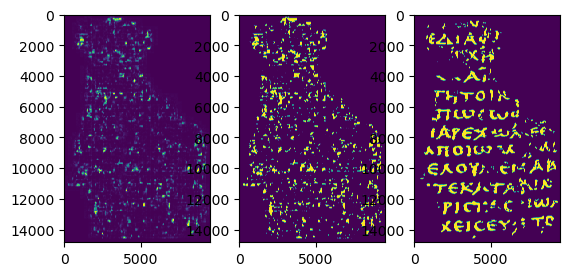

Epoch 1 - Save Best AUC: 0.7478. Model is saved.


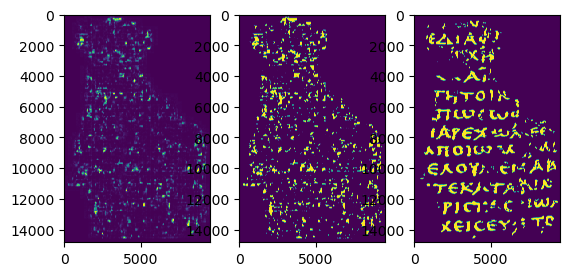

- epoch:2 -
Epoch: [2][0/58] Elapsed 0m 0s (remain 0m 54s) Loss: 0.2733(0.2733) 
Epoch: [2][57/58] Elapsed 0m 16s (remain 0m 0s) Loss: 0.0824(0.2066) 
EVAL: [0/99] Elapsed 0m 0s (remain 0m 26s) Loss: 0.0151(0.0151) 
EVAL: [98/99] Elapsed 0m 17s (remain 0m 0s) Loss: 0.0140(0.5876) 
	 th: 0.1, fbeta: 0.3478538093233647
	 th: 0.15, fbeta: 0.34986838999492703
	 th: 0.2, fbeta: 0.34803369059914924
	 th: 0.25, fbeta: 0.3406445329870635
	 th: 0.3, fbeta: 0.32936423864974673
	 th: 0.35, fbeta: 0.31662374039742824
	 th: 0.4, fbeta: 0.30343676541251124
	 th: 0.45, fbeta: 0.28832509358148195
	 th: 0.5, fbeta: 0.27128317573658145
	 th: 0.55, fbeta: 0.25303242589366026
	 th: 0.6, fbeta: 0.23273063216903286
	 th: 0.65, fbeta: 0.21055164985744604
	 th: 0.7, fbeta: 0.18691012358453876
	 th: 0.75, fbeta: 0.16299246476655943
	 th: 0.8, fbeta: 0.13760184501186115
	 th: 0.85, fbeta: 0.1128486152886785
	 th: 0.9, fbeta: 0.0862222570788151
	 th: 0.95, fbeta: 0.055728672922180617
	 th: 1.0, fbeta: 0.0
	 epoc

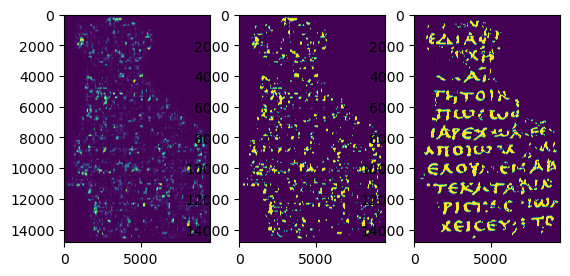

Epoch 2 - Save Best AUC: 0.7726. Model is saved.


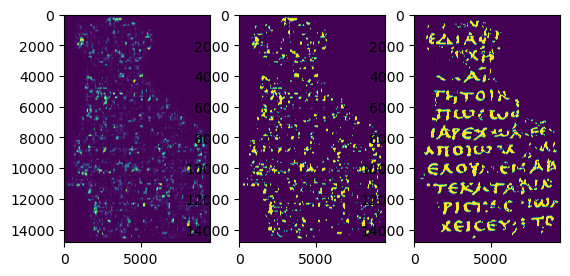

- epoch:3 -
Epoch: [3][0/58] Elapsed 0m 0s (remain 0m 52s) Loss: 0.1445(0.1445) 
Epoch: [3][57/58] Elapsed 0m 16s (remain 0m 0s) Loss: 0.1756(0.1822) 
EVAL: [0/99] Elapsed 0m 0s (remain 0m 27s) Loss: 0.0101(0.0101) 
EVAL: [98/99] Elapsed 0m 17s (remain 0m 0s) Loss: 0.0107(0.6046) 
	 th: 0.1, fbeta: 0.3608669668996586
	 th: 0.15, fbeta: 0.3561590007719207
	 th: 0.2, fbeta: 0.3437459259462202
	 th: 0.25, fbeta: 0.3246153053170682
	 th: 0.3, fbeta: 0.3014952810029311
	 th: 0.35, fbeta: 0.27479225146600106
	 th: 0.4, fbeta: 0.24777015957513115
	 th: 0.45, fbeta: 0.22277670810407219
	 th: 0.5, fbeta: 0.19945266804725129
	 th: 0.55, fbeta: 0.1764468246695456
	 th: 0.6, fbeta: 0.15327229410496673
	 th: 0.65, fbeta: 0.13085410282411286
	 th: 0.7, fbeta: 0.1103092942455697
	 th: 0.75, fbeta: 0.09242673194745317
	 th: 0.8, fbeta: 0.0759035152364606
	 th: 0.85, fbeta: 0.058482375243793905
	 th: 0.9, fbeta: 0.04227789194260903
	 th: 0.95, fbeta: 0.025743035043780674
	 th: 1.0, fbeta: 0.0
	 epoch:3

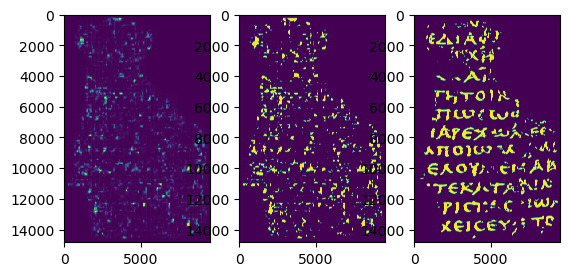

Epoch 3 - Save Best AUC: 0.7755. Model is saved.


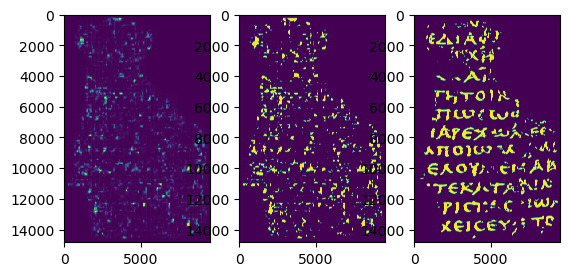

- epoch:4 -
Epoch: [4][0/58] Elapsed 0m 1s (remain 1m 0s) Loss: 0.1838(0.1838) 
Epoch: [4][57/58] Elapsed 0m 16s (remain 0m 0s) Loss: 0.2006(0.1577) 
EVAL: [0/99] Elapsed 0m 0s (remain 0m 27s) Loss: 0.0110(0.0110) 
EVAL: [98/99] Elapsed 0m 17s (remain 0m 0s) Loss: 0.0138(0.5732) 
	 th: 0.1, fbeta: 0.34922007701388535
	 th: 0.15, fbeta: 0.35797781834381953
	 th: 0.2, fbeta: 0.3602828092324162
	 th: 0.25, fbeta: 0.3576537480111544
	 th: 0.3, fbeta: 0.35032206325327325
	 th: 0.35, fbeta: 0.3386996043674611
	 th: 0.4, fbeta: 0.3229560607516617
	 th: 0.45, fbeta: 0.3026836720308905
	 th: 0.5, fbeta: 0.28015906189977774
	 th: 0.55, fbeta: 0.25633255814523254
	 th: 0.6, fbeta: 0.23184873166712613
	 th: 0.65, fbeta: 0.20407968808985144
	 th: 0.7, fbeta: 0.17599279138284116
	 th: 0.75, fbeta: 0.14820295218172885
	 th: 0.8, fbeta: 0.12117324210766
	 th: 0.85, fbeta: 0.09184055669631586
	 th: 0.9, fbeta: 0.061471605317209896
	 th: 0.95, fbeta: 0.03444714232857724
	 th: 1.0, fbeta: 0.0
	 epoch:4, 

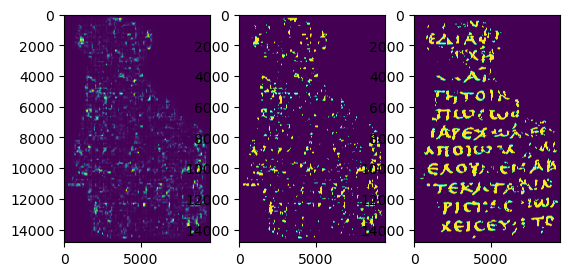

- epoch:5 -
Epoch: [5][0/58] Elapsed 0m 0s (remain 0m 51s) Loss: 0.1608(0.1608) 
Epoch: [5][57/58] Elapsed 0m 16s (remain 0m 0s) Loss: 0.1486(0.1563) 
EVAL: [0/99] Elapsed 0m 0s (remain 0m 27s) Loss: 0.0071(0.0071) 
EVAL: [98/99] Elapsed 0m 17s (remain 0m 0s) Loss: 0.0105(0.5733) 
	 th: 0.1, fbeta: 0.3448760521235757
	 th: 0.15, fbeta: 0.3506191296714547
	 th: 0.2, fbeta: 0.3520613104400984
	 th: 0.25, fbeta: 0.3482885704744884
	 th: 0.3, fbeta: 0.3417899435814054
	 th: 0.35, fbeta: 0.3331337461998355
	 th: 0.4, fbeta: 0.3216678820503499
	 th: 0.45, fbeta: 0.3080291840813769
	 th: 0.5, fbeta: 0.29145117972445944
	 th: 0.55, fbeta: 0.2726531793490356
	 th: 0.6, fbeta: 0.2530225673275309
	 th: 0.65, fbeta: 0.23060765406071315
	 th: 0.7, fbeta: 0.20589760232162196
	 th: 0.75, fbeta: 0.18002489544228978
	 th: 0.8, fbeta: 0.1516562150363041
	 th: 0.85, fbeta: 0.1210262467159453
	 th: 0.9, fbeta: 0.08902984961943439
	 th: 0.95, fbeta: 0.056059621115805806
	 th: 1.0, fbeta: 0.0008445619331562

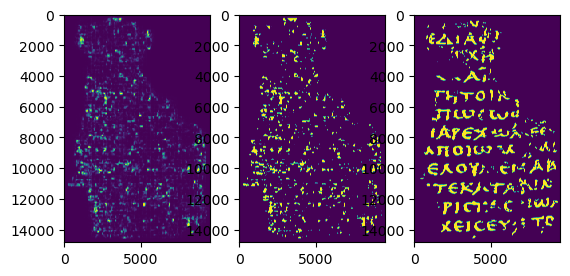

- epoch:6 -
Epoch: [6][0/58] Elapsed 0m 0s (remain 0m 56s) Loss: 0.1566(0.1566) 
Epoch: [6][57/58] Elapsed 0m 16s (remain 0m 0s) Loss: 0.3798(0.1515) 
EVAL: [0/99] Elapsed 0m 0s (remain 0m 28s) Loss: 0.0166(0.0166) 
EVAL: [98/99] Elapsed 0m 17s (remain 0m 0s) Loss: 0.0229(0.6168) 
	 th: 0.1, fbeta: 0.3221826527523225
	 th: 0.15, fbeta: 0.32101230489378213
	 th: 0.2, fbeta: 0.31136115744670195
	 th: 0.25, fbeta: 0.30139412223297724
	 th: 0.3, fbeta: 0.2904480521778329
	 th: 0.35, fbeta: 0.2764353127463458
	 th: 0.4, fbeta: 0.25906574509260943
	 th: 0.45, fbeta: 0.2399613450442428
	 th: 0.5, fbeta: 0.22162845571464307
	 th: 0.55, fbeta: 0.20406676691582443
	 th: 0.6, fbeta: 0.1856293877203543
	 th: 0.65, fbeta: 0.16624324598737347
	 th: 0.7, fbeta: 0.14520092967267417
	 th: 0.75, fbeta: 0.12374397914301087
	 th: 0.8, fbeta: 0.10172867514157152
	 th: 0.85, fbeta: 0.08198033875997288
	 th: 0.9, fbeta: 0.06213649057089931
	 th: 0.95, fbeta: 0.04222094698674224
	 th: 1.0, fbeta: 0.0012232957

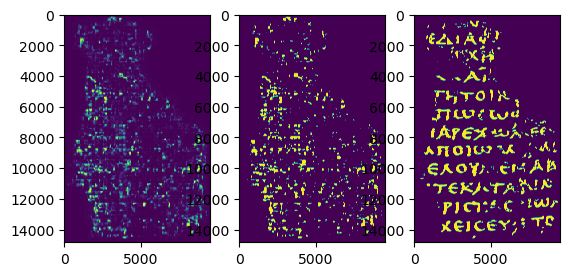

- epoch:8 -
Epoch: [8][0/58] Elapsed 0m 0s (remain 0m 52s) Loss: 0.1336(0.1336) 
Epoch: [8][57/58] Elapsed 0m 16s (remain 0m 0s) Loss: 0.1890(0.1578) 
EVAL: [0/99] Elapsed 0m 0s (remain 0m 27s) Loss: 0.0130(0.0130) 
EVAL: [98/99] Elapsed 0m 17s (remain 0m 0s) Loss: 0.0122(0.6796) 
	 th: 0.1, fbeta: 0.3283071523917879
	 th: 0.15, fbeta: 0.31024723962654854
	 th: 0.2, fbeta: 0.290755874678123
	 th: 0.25, fbeta: 0.2695512578520689
	 th: 0.3, fbeta: 0.24861901294162086
	 th: 0.35, fbeta: 0.22822033604006348
	 th: 0.4, fbeta: 0.2089514235449226
	 th: 0.45, fbeta: 0.19053619604990069
	 th: 0.5, fbeta: 0.17268609256578304
	 th: 0.55, fbeta: 0.15526788757988647
	 th: 0.6, fbeta: 0.13830405135282003
	 th: 0.65, fbeta: 0.12318090304650722
	 th: 0.7, fbeta: 0.10821888210012064
	 th: 0.75, fbeta: 0.0928203903842952
	 th: 0.8, fbeta: 0.07631334617902465
	 th: 0.85, fbeta: 0.05941428848908927
	 th: 0.9, fbeta: 0.042400979703695996
	 th: 0.95, fbeta: 0.025160764394986854
	 th: 1.0, fbeta: 0.0
	 epoch

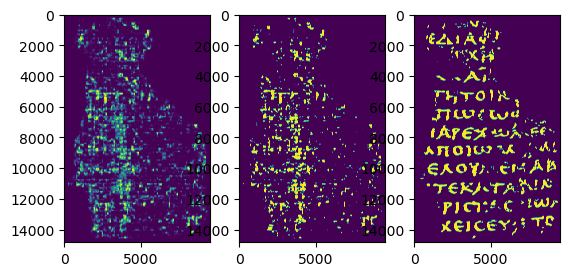

Epoch 13 - Save Best AUC: 0.7919. Model is saved.


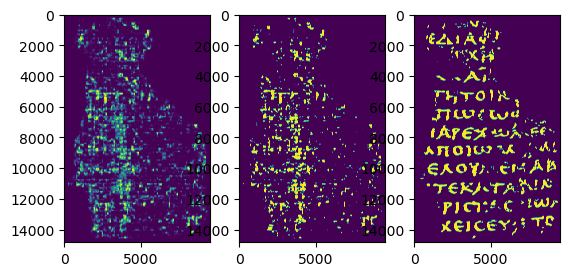

- epoch:14 -
Epoch: [14][0/58] Elapsed 0m 1s (remain 0m 58s) Loss: 0.1758(0.1758) 
Epoch: [14][57/58] Elapsed 0m 16s (remain 0m 0s) Loss: 0.1035(0.1389) 
EVAL: [0/99] Elapsed 0m 0s (remain 0m 27s) Loss: 0.0062(0.0062) 
EVAL: [98/99] Elapsed 0m 17s (remain 0m 0s) Loss: 0.0048(0.7083) 
	 th: 0.1, fbeta: 0.3071961606341949
	 th: 0.15, fbeta: 0.2761604632933414
	 th: 0.2, fbeta: 0.24534291522743995
	 th: 0.25, fbeta: 0.21765972614113915
	 th: 0.3, fbeta: 0.1927416111707967
	 th: 0.35, fbeta: 0.17157645327977333
	 th: 0.4, fbeta: 0.15265113034880987
	 th: 0.45, fbeta: 0.13372039916857134
	 th: 0.5, fbeta: 0.11614398593849642
	 th: 0.55, fbeta: 0.09922295078677303
	 th: 0.6, fbeta: 0.08367669943957258
	 th: 0.65, fbeta: 0.06922983580285576
	 th: 0.7, fbeta: 0.05591832440164663
	 th: 0.75, fbeta: 0.04450173298605062
	 th: 0.8, fbeta: 0.03360869116516419
	 th: 0.85, fbeta: 0.024402304901717548
	 th: 0.9, fbeta: 0.016751388022374743
	 th: 0.95, fbeta: 0.010042674721215061
	 th: 1.0, fbeta: 0.0


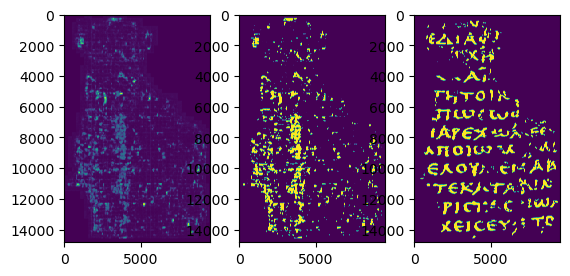

[fold1] slice ave score:0.3830(th=0.150000), auc=0.784704
[fold1] BEST Epoch 13 - Save Best Score:0.3825. Best loss:0.5615
[fold1] BEST AUC Epoch 13 - Save Best Score:0.7919. Best loss:0.5615
-- fold2 training start --
surface_list:  range(26, 36, 3)
initializing dataset...
/working/input/vesuvius-challenge-ink-detection/train/2/mask.png
/working/input/vesuvius-challenge-ink-detection/train/3/mask.png
reading surface volume...
 reading idx : 4/4  => read surface volume done. [2]
 reading idx : 4/4  => read surface volume done. [3]
split grid done.
initializing dataset done.
initializing dataset...
/working/input/vesuvius-challenge-ink-detection/train/1/mask.png
reading surface volume...
 reading idx : 4/4  => read surface volume done. [1]
split grid done.
initializing dataset done.
- epoch:1 -
Epoch: [1][0/125] Elapsed 0m 0s (remain 1m 58s) Loss: 0.7879(0.7879) 
Epoch: [1][124/125] Elapsed 0m 34s (remain 0m 0s) Loss: 0.5202(0.6536) 
EVAL: [0/31] Elapsed 0m 0s (remain 0m 8s) Loss: 0.443

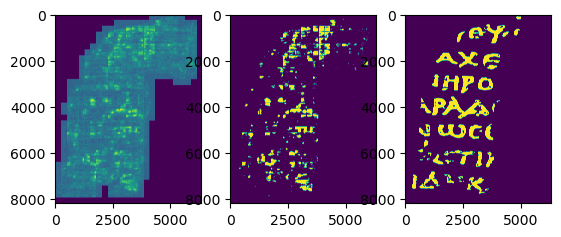

Epoch 1 - Save Best AUC: 0.8412. Model is saved.


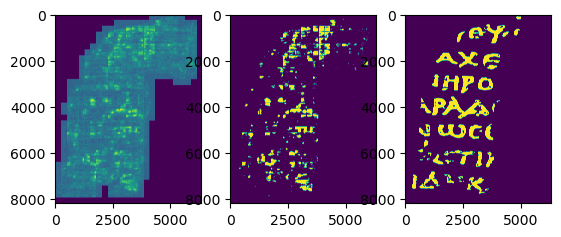

- epoch:2 -
Epoch: [2][0/125] Elapsed 0m 0s (remain 1m 59s) Loss: 0.5826(0.5826) 
Epoch: [2][124/125] Elapsed 0m 34s (remain 0m 0s) Loss: 0.4456(0.4808) 
EVAL: [0/31] Elapsed 0m 0s (remain 0m 8s) Loss: 0.3910(0.3910) 
EVAL: [30/31] Elapsed 0m 5s (remain 0m 0s) Loss: 0.2403(0.5094) 
	 th: 0.1, fbeta: 0.19892862674246245
	 th: 0.15, fbeta: 0.2287849248584701
	 th: 0.2, fbeta: 0.26067912434262425
	 th: 0.25, fbeta: 0.290235774143198
	 th: 0.3, fbeta: 0.3177118057745954
	 th: 0.35, fbeta: 0.3395187638750992
	 th: 0.4, fbeta: 0.3579297957847569
	 th: 0.45, fbeta: 0.3721637905762106
	 th: 0.5, fbeta: 0.3830251111639274
	 th: 0.55, fbeta: 0.390569309347746
	 th: 0.6, fbeta: 0.39642186342434027
	 th: 0.65, fbeta: 0.39978616736084915
	 th: 0.7, fbeta: 0.39433619413034127
	 th: 0.75, fbeta: 0.3751929879001428
	 th: 0.8, fbeta: 0.3345413372569736
	 th: 0.85, fbeta: 0.24429754953167993
	 th: 0.9, fbeta: 0.10656822381211073
	 th: 0.95, fbeta: 0.0032568278839359695
	 th: 1.0, fbeta: 0.0
	 epoch:2, a

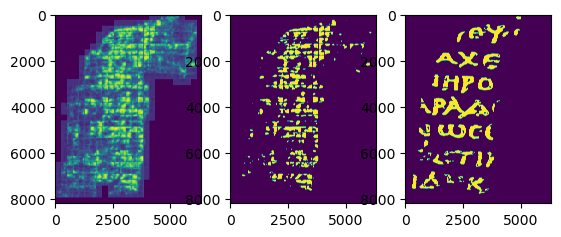

Epoch 2 - Save Best AUC: 0.8637. Model is saved.


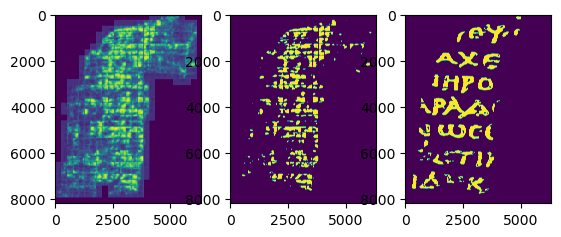

- epoch:3 -
Epoch: [3][0/125] Elapsed 0m 0s (remain 1m 54s) Loss: 0.3920(0.3920) 
Epoch: [3][124/125] Elapsed 0m 35s (remain 0m 0s) Loss: 0.2824(0.3842) 
EVAL: [0/31] Elapsed 0m 0s (remain 0m 9s) Loss: 0.2672(0.2672) 
EVAL: [30/31] Elapsed 0m 5s (remain 0m 0s) Loss: 0.1958(0.4562) 
	 th: 0.1, fbeta: 0.23688956659174246
	 th: 0.15, fbeta: 0.25943297667037596
	 th: 0.2, fbeta: 0.2904269394857652
	 th: 0.25, fbeta: 0.31873561622695534
	 th: 0.3, fbeta: 0.34363906122882704
	 th: 0.35, fbeta: 0.366227871507188
	 th: 0.4, fbeta: 0.38816615624137707
	 th: 0.45, fbeta: 0.4077016099050025
	 th: 0.5, fbeta: 0.4241962790443578
	 th: 0.55, fbeta: 0.4377440432090114
	 th: 0.6, fbeta: 0.44955456754312034
	 th: 0.65, fbeta: 0.45840337726086156
	 th: 0.7, fbeta: 0.46156164222996915
	 th: 0.75, fbeta: 0.45586414761353844
	 th: 0.8, fbeta: 0.4373343780945714
	 th: 0.85, fbeta: 0.39760350034731834
	 th: 0.9, fbeta: 0.31863546405953197
	 th: 0.95, fbeta: 0.18191543422171005
	 th: 1.0, fbeta: 0.0
	 epoch:3

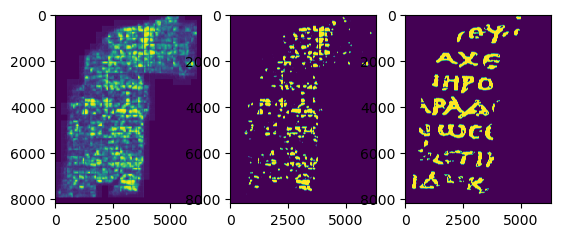

Epoch 3 - Save Best AUC: 0.8765. Model is saved.


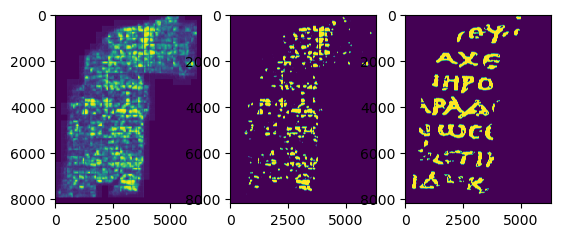

- epoch:4 -
Epoch: [4][0/125] Elapsed 0m 0s (remain 1m 54s) Loss: 0.4131(0.4131) 
Epoch: [4][124/125] Elapsed 0m 34s (remain 0m 0s) Loss: 0.3328(0.3485) 
EVAL: [0/31] Elapsed 0m 0s (remain 0m 8s) Loss: 0.2396(0.2396) 
EVAL: [30/31] Elapsed 0m 5s (remain 0m 0s) Loss: 0.1674(0.4037) 
	 th: 0.1, fbeta: 0.2503828040617951
	 th: 0.15, fbeta: 0.2747815259795121
	 th: 0.2, fbeta: 0.29843490444303006
	 th: 0.25, fbeta: 0.32489977533920733
	 th: 0.3, fbeta: 0.35132205840649094
	 th: 0.35, fbeta: 0.3756748266633229
	 th: 0.4, fbeta: 0.3972125161345576
	 th: 0.45, fbeta: 0.4132988511135918
	 th: 0.5, fbeta: 0.42379507336226374
	 th: 0.55, fbeta: 0.4229832364647836
	 th: 0.6, fbeta: 0.40721182851022963
	 th: 0.65, fbeta: 0.3693213508159234
	 th: 0.7, fbeta: 0.3100784713463842
	 th: 0.75, fbeta: 0.22106243438870093
	 th: 0.8, fbeta: 0.12011152607574663
	 th: 0.85, fbeta: 0.04114758271290449
	 th: 0.9, fbeta: 0.005693112481609685
	 th: 0.95, fbeta: 0.0
	 th: 1.0, fbeta: 0.0
	 epoch:4, avg train loss

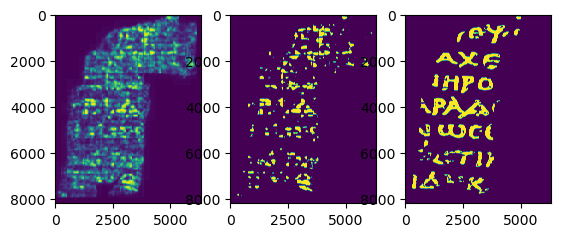

Epoch 6 - Save Best AUC: 0.8784. Model is saved.


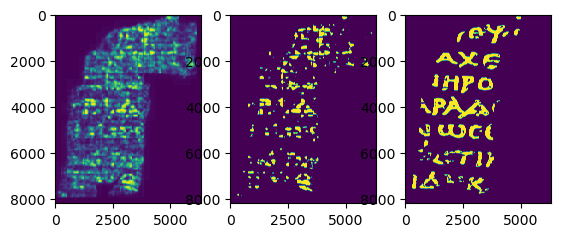

- epoch:7 -
Epoch: [7][0/125] Elapsed 0m 0s (remain 1m 58s) Loss: 0.2441(0.2441) 
Epoch: [7][124/125] Elapsed 0m 34s (remain 0m 0s) Loss: 0.2732(0.2920) 
EVAL: [0/31] Elapsed 0m 0s (remain 0m 8s) Loss: 0.1681(0.1681) 
EVAL: [30/31] Elapsed 0m 5s (remain 0m 0s) Loss: 0.1024(0.3615) 
	 th: 0.1, fbeta: 0.3021753145831236
	 th: 0.15, fbeta: 0.3438002159336526
	 th: 0.2, fbeta: 0.3800872148981775
	 th: 0.25, fbeta: 0.4136089558933933
	 th: 0.3, fbeta: 0.44196793794134115
	 th: 0.35, fbeta: 0.46469507232206164
	 th: 0.4, fbeta: 0.48082465137454
	 th: 0.45, fbeta: 0.4920828394079279
	 th: 0.5, fbeta: 0.4972946140245807
	 th: 0.55, fbeta: 0.497168399268293
	 th: 0.6, fbeta: 0.4909412409107688
	 th: 0.65, fbeta: 0.4798544988753781
	 th: 0.7, fbeta: 0.4635307268255376
	 th: 0.75, fbeta: 0.4396699981747015
	 th: 0.8, fbeta: 0.40664566531064456
	 th: 0.85, fbeta: 0.35329052785681014
	 th: 0.9, fbeta: 0.2670047206358671
	 th: 0.95, fbeta: 0.1300752452221365
	 th: 1.0, fbeta: 0.0
	 epoch:7, avg trai

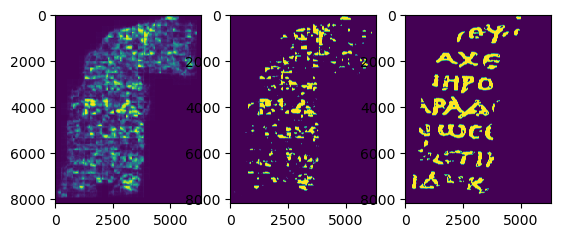

Epoch 7 - Save Best AUC: 0.8865. Model is saved.


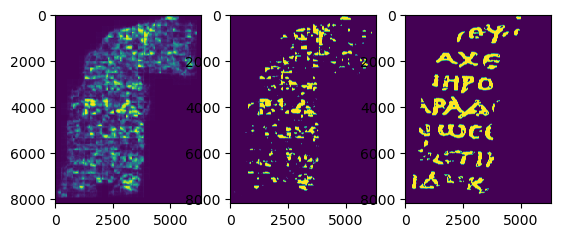

- epoch:8 -
Epoch: [8][0/125] Elapsed 0m 1s (remain 2m 7s) Loss: 0.3547(0.3547) 
Epoch: [8][124/125] Elapsed 0m 34s (remain 0m 0s) Loss: 0.2708(0.2751) 
EVAL: [0/31] Elapsed 0m 0s (remain 0m 8s) Loss: 0.2549(0.2549) 
EVAL: [30/31] Elapsed 0m 5s (remain 0m 0s) Loss: 0.1244(0.3823) 
	 th: 0.1, fbeta: 0.2912084326519453
	 th: 0.15, fbeta: 0.3250023686700461
	 th: 0.2, fbeta: 0.3547810919745363
	 th: 0.25, fbeta: 0.38389544824532285
	 th: 0.3, fbeta: 0.4103839265548041
	 th: 0.35, fbeta: 0.43251651576626116
	 th: 0.4, fbeta: 0.45102138540916026
	 th: 0.45, fbeta: 0.46685291206749374
	 th: 0.5, fbeta: 0.4796860486524327
	 th: 0.55, fbeta: 0.48953278419865376
	 th: 0.6, fbeta: 0.49487653420811817
	 th: 0.65, fbeta: 0.4950023874869976
	 th: 0.7, fbeta: 0.48796720109445324
	 th: 0.75, fbeta: 0.47096859050039375
	 th: 0.8, fbeta: 0.4374140662729097
	 th: 0.85, fbeta: 0.3837547659004075
	 th: 0.9, fbeta: 0.3021932986421304
	 th: 0.95, fbeta: 0.15605876933545212
	 th: 1.0, fbeta: 0.0
	 epoch:8, a

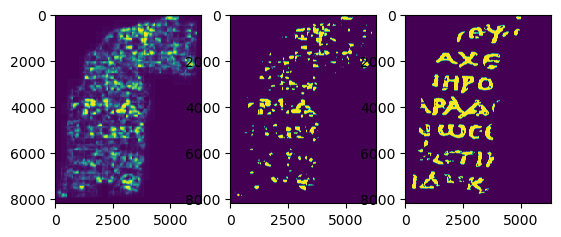

- epoch:11 -
Epoch: [11][0/125] Elapsed 0m 1s (remain 2m 7s) Loss: 0.1982(0.1982) 
Epoch: [11][124/125] Elapsed 0m 35s (remain 0m 0s) Loss: 0.2170(0.2571) 
EVAL: [0/31] Elapsed 0m 0s (remain 0m 10s) Loss: 0.2579(0.2579) 
EVAL: [30/31] Elapsed 0m 5s (remain 0m 0s) Loss: 0.1302(0.3916) 
	 th: 0.1, fbeta: 0.29845029886937874
	 th: 0.15, fbeta: 0.33220522976376365
	 th: 0.2, fbeta: 0.36049452729175946
	 th: 0.25, fbeta: 0.38771048446865625
	 th: 0.3, fbeta: 0.4121077478027355
	 th: 0.35, fbeta: 0.43119652900080435
	 th: 0.4, fbeta: 0.44978505170134525
	 th: 0.45, fbeta: 0.46615495810891
	 th: 0.5, fbeta: 0.4792807055200021
	 th: 0.55, fbeta: 0.48783758414577205
	 th: 0.6, fbeta: 0.4928582350427909
	 th: 0.65, fbeta: 0.4946297906547347
	 th: 0.7, fbeta: 0.49168831920104045
	 th: 0.75, fbeta: 0.4850062511144144
	 th: 0.8, fbeta: 0.4703280480494619
	 th: 0.85, fbeta: 0.44040526791523726
	 th: 0.9, fbeta: 0.38568886357666654
	 th: 0.95, fbeta: 0.27493590598597795
	 th: 1.0, fbeta: 0.0
	 epoch:

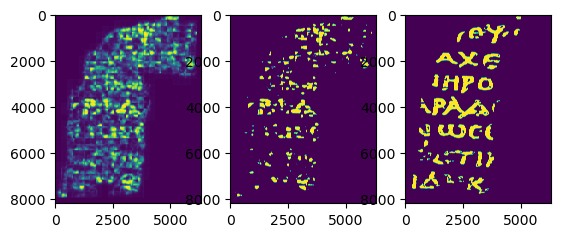

- epoch:13 -
Epoch: [13][0/125] Elapsed 0m 1s (remain 2m 7s) Loss: 0.3055(0.3055) 
Epoch: [13][124/125] Elapsed 0m 35s (remain 0m 0s) Loss: 0.3033(0.2567) 
EVAL: [0/31] Elapsed 0m 0s (remain 0m 9s) Loss: 0.2108(0.2108) 
EVAL: [30/31] Elapsed 0m 5s (remain 0m 0s) Loss: 0.1256(0.3731) 
	 th: 0.1, fbeta: 0.3140784920612652
	 th: 0.15, fbeta: 0.3569448311123577
	 th: 0.2, fbeta: 0.3928815740191088
	 th: 0.25, fbeta: 0.42194173741352
	 th: 0.3, fbeta: 0.44516002229595164
	 th: 0.35, fbeta: 0.4661123903690819
	 th: 0.4, fbeta: 0.4839377902183745
	 th: 0.45, fbeta: 0.49681741891663683
	 th: 0.5, fbeta: 0.505934602167136
	 th: 0.55, fbeta: 0.5103660799781711
	 th: 0.6, fbeta: 0.5109868480216723
	 th: 0.65, fbeta: 0.5059349580807769
	 th: 0.7, fbeta: 0.49832931173502476
	 th: 0.75, fbeta: 0.4861692621227734
	 th: 0.8, fbeta: 0.4662626634911404
	 th: 0.85, fbeta: 0.43512870829298145
	 th: 0.9, fbeta: 0.3780671187784189
	 th: 0.95, fbeta: 0.2776071235335704
	 th: 1.0, fbeta: 0.0
	 epoch:13, avg t

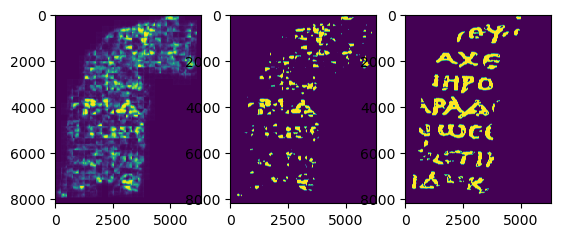

- epoch:14 -
Epoch: [14][0/125] Elapsed 0m 1s (remain 2m 17s) Loss: 0.2336(0.2336) 
Epoch: [14][124/125] Elapsed 0m 34s (remain 0m 0s) Loss: 0.3149(0.2562) 
EVAL: [0/31] Elapsed 0m 0s (remain 0m 9s) Loss: 0.2442(0.2442) 
EVAL: [30/31] Elapsed 0m 5s (remain 0m 0s) Loss: 0.1314(0.3864) 
	 th: 0.1, fbeta: 0.32445728095040954
	 th: 0.15, fbeta: 0.35650869792950396
	 th: 0.2, fbeta: 0.3842127270861338
	 th: 0.25, fbeta: 0.4087183950163444
	 th: 0.3, fbeta: 0.43085554058953557
	 th: 0.35, fbeta: 0.44993999017917685
	 th: 0.4, fbeta: 0.46457035778143496
	 th: 0.45, fbeta: 0.4730067511310306
	 th: 0.5, fbeta: 0.47705676293917787
	 th: 0.55, fbeta: 0.48157109354349287
	 th: 0.6, fbeta: 0.4855246839137687
	 th: 0.65, fbeta: 0.48773733356858745
	 th: 0.7, fbeta: 0.4849118826805714
	 th: 0.75, fbeta: 0.4738160745306542
	 th: 0.8, fbeta: 0.4535020386117359
	 th: 0.85, fbeta: 0.4189776356478365
	 th: 0.9, fbeta: 0.35514442249031153
	 th: 0.95, fbeta: 0.25073544017317095
	 th: 1.0, fbeta: 0.0
	 epoch

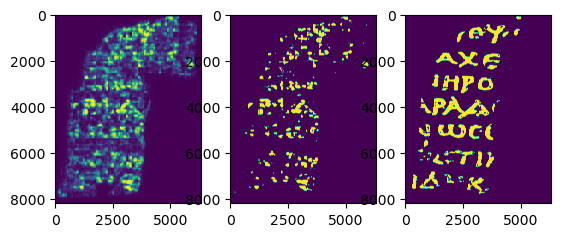

Epoch 1 - Save Best AUC: 0.8881. Model is saved.


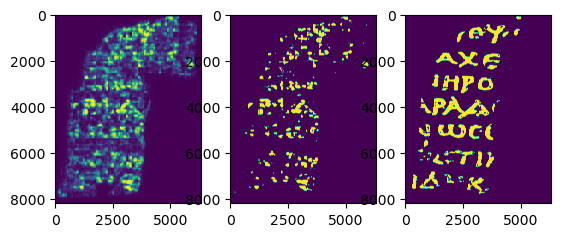

- epoch:2 -
Epoch: [2][0/125] Elapsed 0m 1s (remain 2m 10s) Loss: 0.2732(0.2732) 
Epoch: [2][124/125] Elapsed 0m 35s (remain 0m 0s) Loss: 0.2139(0.2637) 
EVAL: [0/31] Elapsed 0m 0s (remain 0m 9s) Loss: 0.1502(0.1502) 
EVAL: [30/31] Elapsed 0m 5s (remain 0m 0s) Loss: 0.0964(0.3731) 
	 th: 0.1, fbeta: 0.3440724728575188
	 th: 0.15, fbeta: 0.3846049095879702
	 th: 0.2, fbeta: 0.41514812434658227
	 th: 0.25, fbeta: 0.43825050525231685
	 th: 0.3, fbeta: 0.455487254984136
	 th: 0.35, fbeta: 0.4694747882745493
	 th: 0.4, fbeta: 0.4807998043095738
	 th: 0.45, fbeta: 0.49045610711088633
	 th: 0.5, fbeta: 0.49882407219830177
	 th: 0.55, fbeta: 0.5063771406863231
	 th: 0.6, fbeta: 0.5111510946952208
	 th: 0.65, fbeta: 0.514607379661896
	 th: 0.7, fbeta: 0.5145871566317763
	 th: 0.75, fbeta: 0.5084474329207588
	 th: 0.8, fbeta: 0.49098482554993583
	 th: 0.85, fbeta: 0.4537724542610988
	 th: 0.9, fbeta: 0.38650847400581306
	 th: 0.95, fbeta: 0.24810082174744516
	 th: 1.0, fbeta: 0.0
	 epoch:2, avg 

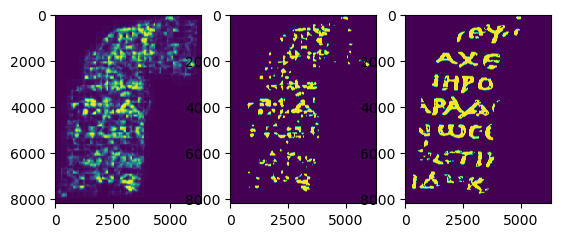

Epoch 2 - Save Best AUC: 0.8922. Model is saved.


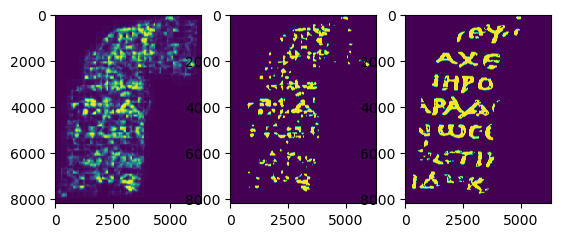

- epoch:3 -
Epoch: [3][0/125] Elapsed 0m 1s (remain 2m 18s) Loss: 0.4034(0.4034) 
Epoch: [3][124/125] Elapsed 0m 34s (remain 0m 0s) Loss: 0.3329(0.2619) 
EVAL: [0/31] Elapsed 0m 0s (remain 0m 8s) Loss: 0.2154(0.2154) 
EVAL: [30/31] Elapsed 0m 5s (remain 0m 0s) Loss: 0.1908(0.4598) 
	 th: 0.1, fbeta: 0.28054965138753973
	 th: 0.15, fbeta: 0.3013419011561665
	 th: 0.2, fbeta: 0.3205112706892329
	 th: 0.25, fbeta: 0.3378277588860039
	 th: 0.3, fbeta: 0.35206482968459163
	 th: 0.35, fbeta: 0.36455441074872036
	 th: 0.4, fbeta: 0.3763459248922677
	 th: 0.45, fbeta: 0.38865706161519603
	 th: 0.5, fbeta: 0.4017451433762718
	 th: 0.55, fbeta: 0.4158801827453693
	 th: 0.6, fbeta: 0.4304182345935206
	 th: 0.65, fbeta: 0.44324266838875526
	 th: 0.7, fbeta: 0.4510481404452573
	 th: 0.75, fbeta: 0.4507182383335327
	 th: 0.8, fbeta: 0.44394362432511664
	 th: 0.85, fbeta: 0.4229816866432163
	 th: 0.9, fbeta: 0.3621294260074865
	 th: 0.95, fbeta: 0.20147868831322646
	 th: 1.0, fbeta: 0.0
	 epoch:3, av

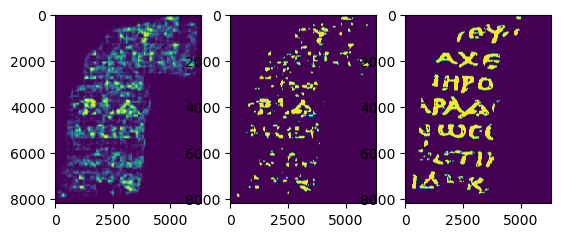

- epoch:7 -
Epoch: [7][0/125] Elapsed 0m 1s (remain 2m 13s) Loss: 0.2573(0.2573) 
Epoch: [7][124/125] Elapsed 0m 36s (remain 0m 0s) Loss: 0.1614(0.2426) 
EVAL: [0/31] Elapsed 0m 0s (remain 0m 9s) Loss: 0.1650(0.1650) 
EVAL: [30/31] Elapsed 0m 5s (remain 0m 0s) Loss: 0.1453(0.3856) 
	 th: 0.1, fbeta: 0.3037213614578906
	 th: 0.15, fbeta: 0.33369422340524635
	 th: 0.2, fbeta: 0.3588287077857306
	 th: 0.25, fbeta: 0.3800236946661991
	 th: 0.3, fbeta: 0.4005323982164454
	 th: 0.35, fbeta: 0.41999141597927087
	 th: 0.4, fbeta: 0.43666937270732
	 th: 0.45, fbeta: 0.4512685472967342
	 th: 0.5, fbeta: 0.46504159277579943
	 th: 0.55, fbeta: 0.4779103277995483
	 th: 0.6, fbeta: 0.48907940193765026
	 th: 0.65, fbeta: 0.4918351378726278
	 th: 0.7, fbeta: 0.4881441352309859
	 th: 0.75, fbeta: 0.4731980169540859
	 th: 0.8, fbeta: 0.4421092918250929
	 th: 0.85, fbeta: 0.39013538166250633
	 th: 0.9, fbeta: 0.30777379670123534
	 th: 0.95, fbeta: 0.17467301464863877
	 th: 1.0, fbeta: 0.0
	 epoch:7, avg 

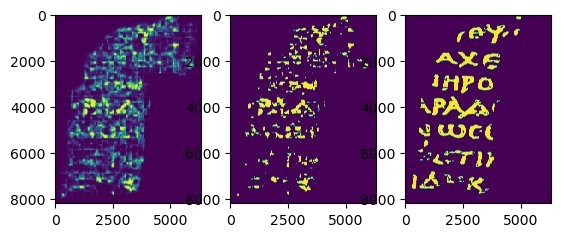

Epoch 11 - Save Best AUC: 0.8979. Model is saved.


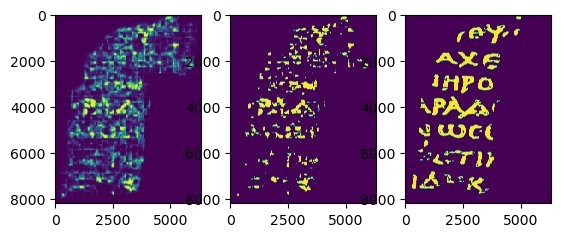

- epoch:12 -
Epoch: [12][0/125] Elapsed 0m 1s (remain 2m 16s) Loss: 0.1450(0.1450) 
Epoch: [12][124/125] Elapsed 0m 35s (remain 0m 0s) Loss: 0.1742(0.1794) 
EVAL: [0/31] Elapsed 0m 0s (remain 0m 9s) Loss: 0.1933(0.1933) 
EVAL: [30/31] Elapsed 0m 5s (remain 0m 0s) Loss: 0.1434(0.4280) 
	 th: 0.1, fbeta: 0.312351603441743
	 th: 0.15, fbeta: 0.33606118460363105
	 th: 0.2, fbeta: 0.3557067808778331
	 th: 0.25, fbeta: 0.3738734122238935
	 th: 0.3, fbeta: 0.39086451624697915
	 th: 0.35, fbeta: 0.4075463185866388
	 th: 0.4, fbeta: 0.4224028436724384
	 th: 0.45, fbeta: 0.43751091725778685
	 th: 0.5, fbeta: 0.45279796399329786
	 th: 0.55, fbeta: 0.46789346540535887
	 th: 0.6, fbeta: 0.484156642854856
	 th: 0.65, fbeta: 0.49975217730109217
	 th: 0.7, fbeta: 0.5139289598401724
	 th: 0.75, fbeta: 0.5252570416688765
	 th: 0.8, fbeta: 0.5296046618069478
	 th: 0.85, fbeta: 0.5256078546376418
	 th: 0.9, fbeta: 0.4987144800289404
	 th: 0.95, fbeta: 0.42964142344625833
	 th: 1.0, fbeta: 0.0
	 epoch:12, 

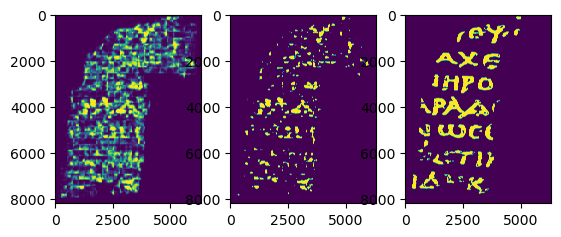

Epoch 1 - Save Best AUC: 0.8809. Model is saved.


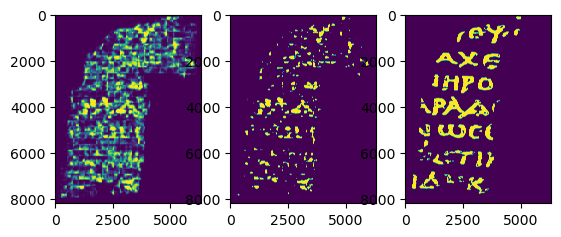

- epoch:2 -
Epoch: [2][0/125] Elapsed 0m 1s (remain 2m 8s) Loss: 0.1774(0.1774) 
Epoch: [2][124/125] Elapsed 0m 35s (remain 0m 0s) Loss: 0.2345(0.2180) 
EVAL: [0/31] Elapsed 0m 0s (remain 0m 9s) Loss: 0.2003(0.2003) 
EVAL: [30/31] Elapsed 0m 5s (remain 0m 0s) Loss: 0.1792(0.4393) 
	 th: 0.1, fbeta: 0.30158705551714937
	 th: 0.15, fbeta: 0.32099342066770103
	 th: 0.2, fbeta: 0.3383152787978552
	 th: 0.25, fbeta: 0.3542436993867993
	 th: 0.3, fbeta: 0.3702818068379026
	 th: 0.35, fbeta: 0.3868945033902987
	 th: 0.4, fbeta: 0.40372985902478525
	 th: 0.45, fbeta: 0.41949784833876236
	 th: 0.5, fbeta: 0.43510174099493965
	 th: 0.55, fbeta: 0.4503042776807585
	 th: 0.6, fbeta: 0.46412827120488165
	 th: 0.65, fbeta: 0.47672866822058335
	 th: 0.7, fbeta: 0.48671037377577825
	 th: 0.75, fbeta: 0.4886597239888901
	 th: 0.8, fbeta: 0.48367428142016505
	 th: 0.85, fbeta: 0.4725835316910395
	 th: 0.9, fbeta: 0.4375517834225582
	 th: 0.95, fbeta: 0.3708315538989644
	 th: 1.0, fbeta: 0.00338899568099

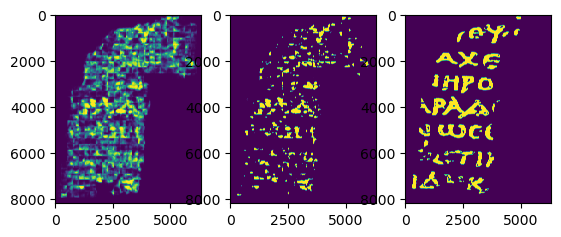

- epoch:3 -
Epoch: [3][0/125] Elapsed 0m 1s (remain 2m 4s) Loss: 0.2586(0.2586) 
Epoch: [3][124/125] Elapsed 0m 35s (remain 0m 0s) Loss: 0.1193(0.2023) 
EVAL: [0/31] Elapsed 0m 0s (remain 0m 8s) Loss: 0.2083(0.2083) 
EVAL: [30/31] Elapsed 0m 5s (remain 0m 0s) Loss: 0.2010(0.4664) 
	 th: 0.1, fbeta: 0.2904079836203605
	 th: 0.15, fbeta: 0.30802852652347057
	 th: 0.2, fbeta: 0.32270024493891486
	 th: 0.25, fbeta: 0.33754521859330355
	 th: 0.3, fbeta: 0.3521692652970561
	 th: 0.35, fbeta: 0.36646183863651977
	 th: 0.4, fbeta: 0.3811359116578362
	 th: 0.45, fbeta: 0.39612237971583547
	 th: 0.5, fbeta: 0.41233039104085545
	 th: 0.55, fbeta: 0.42799784208106395
	 th: 0.6, fbeta: 0.4427556591099962
	 th: 0.65, fbeta: 0.4560125044051734
	 th: 0.7, fbeta: 0.46790304532511034
	 th: 0.75, fbeta: 0.47949844909515055
	 th: 0.8, fbeta: 0.4833127293833256
	 th: 0.85, fbeta: 0.4692069815251138
	 th: 0.9, fbeta: 0.4367009531975569
	 th: 0.95, fbeta: 0.36894381321265096
	 th: 1.0, fbeta: 0.0
	 epoch:3, 

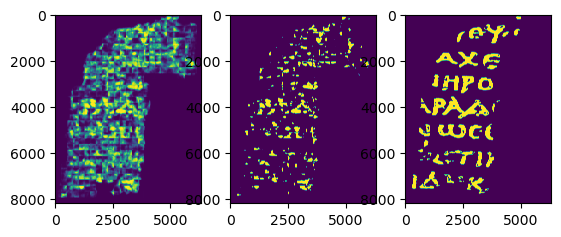

- epoch:4 -
Epoch: [4][0/125] Elapsed 0m 1s (remain 2m 12s) Loss: 0.1685(0.1685) 
Epoch: [4][124/125] Elapsed 0m 35s (remain 0m 0s) Loss: 0.2674(0.1919) 
EVAL: [0/31] Elapsed 0m 0s (remain 0m 9s) Loss: 0.2169(0.2169) 
EVAL: [30/31] Elapsed 0m 5s (remain 0m 0s) Loss: 0.1847(0.4535) 
	 th: 0.1, fbeta: 0.2970447898475563
	 th: 0.15, fbeta: 0.3134293727417689
	 th: 0.2, fbeta: 0.330154902543618
	 th: 0.25, fbeta: 0.34670882409360365
	 th: 0.3, fbeta: 0.3631481991704504
	 th: 0.35, fbeta: 0.3787364780883866
	 th: 0.4, fbeta: 0.3931486833951222
	 th: 0.45, fbeta: 0.4080279893008675
	 th: 0.5, fbeta: 0.4243699678712046
	 th: 0.55, fbeta: 0.440706284946688
	 th: 0.6, fbeta: 0.4565600096837771
	 th: 0.65, fbeta: 0.47191482584599426
	 th: 0.7, fbeta: 0.48479516492699026
	 th: 0.75, fbeta: 0.49477048384197525
	 th: 0.8, fbeta: 0.49808306986634365
	 th: 0.85, fbeta: 0.48724500887581007
	 th: 0.9, fbeta: 0.4487593717974597
	 th: 0.95, fbeta: 0.3473485785043843
	 th: 1.0, fbeta: 0.0
	 epoch:4, avg t

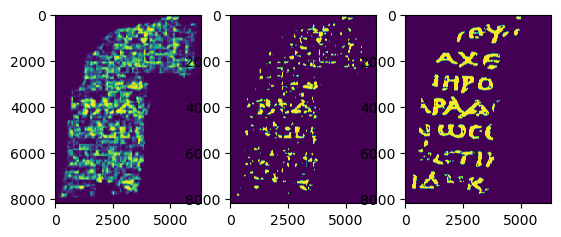

Epoch 4 - Save Best AUC: 0.8842. Model is saved.


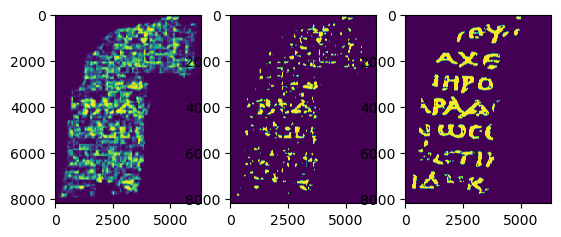

- epoch:5 -
Epoch: [5][0/125] Elapsed 0m 0s (remain 2m 1s) Loss: 0.1617(0.1617) 
Epoch: [5][124/125] Elapsed 0m 34s (remain 0m 0s) Loss: 0.2337(0.1846) 
EVAL: [0/31] Elapsed 0m 0s (remain 0m 9s) Loss: 0.1641(0.1641) 
EVAL: [30/31] Elapsed 0m 5s (remain 0m 0s) Loss: 0.1344(0.3980) 
	 th: 0.1, fbeta: 0.32729928922935947
	 th: 0.15, fbeta: 0.3543901060706575
	 th: 0.2, fbeta: 0.377218789057497
	 th: 0.25, fbeta: 0.3965144712731483
	 th: 0.3, fbeta: 0.41283142832770714
	 th: 0.35, fbeta: 0.4284416697989282
	 th: 0.4, fbeta: 0.44461954874469856
	 th: 0.45, fbeta: 0.4580312846901
	 th: 0.5, fbeta: 0.4700985403481463
	 th: 0.55, fbeta: 0.4811790854929213
	 th: 0.6, fbeta: 0.49016497713314233
	 th: 0.65, fbeta: 0.49511033415256
	 th: 0.7, fbeta: 0.49637432305139734
	 th: 0.75, fbeta: 0.49275457205728895
	 th: 0.8, fbeta: 0.4777337102516483
	 th: 0.85, fbeta: 0.44532434018305767
	 th: 0.9, fbeta: 0.3745490926255306
	 th: 0.95, fbeta: 0.24457688164962502
	 th: 1.0, fbeta: 0.0
	 epoch:5, avg trai

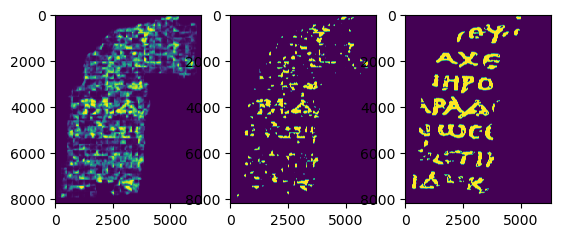

- epoch:6 -
Epoch: [6][0/125] Elapsed 0m 1s (remain 2m 17s) Loss: 0.1564(0.1564) 
Epoch: [6][124/125] Elapsed 0m 34s (remain 0m 0s) Loss: 0.1643(0.1839) 
EVAL: [0/31] Elapsed 0m 0s (remain 0m 9s) Loss: 0.1678(0.1678) 
EVAL: [30/31] Elapsed 0m 5s (remain 0m 0s) Loss: 0.1228(0.4164) 
	 th: 0.1, fbeta: 0.3208381116099057
	 th: 0.15, fbeta: 0.34297814031209306
	 th: 0.2, fbeta: 0.3624845867187853
	 th: 0.25, fbeta: 0.3790733379345814
	 th: 0.3, fbeta: 0.3943711815735893
	 th: 0.35, fbeta: 0.40907700766829613
	 th: 0.4, fbeta: 0.42388704150422873
	 th: 0.45, fbeta: 0.43818607931614867
	 th: 0.5, fbeta: 0.4505247292395057
	 th: 0.55, fbeta: 0.4620905100134852
	 th: 0.6, fbeta: 0.47406337647848673
	 th: 0.65, fbeta: 0.4853328046028718
	 th: 0.7, fbeta: 0.4910537007459082
	 th: 0.75, fbeta: 0.487489776151089
	 th: 0.8, fbeta: 0.4680445357153087
	 th: 0.85, fbeta: 0.43150029881381735
	 th: 0.9, fbeta: 0.37295021421457764
	 th: 0.95, fbeta: 0.2817703023984087
	 th: 1.0, fbeta: 0.0
	 epoch:6, avg

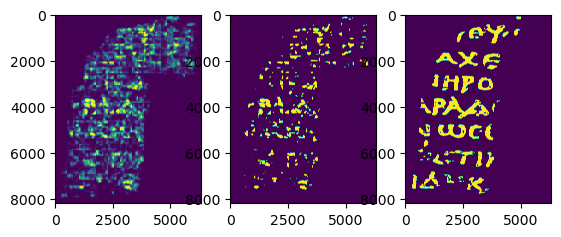

- epoch:10 -
Epoch: [10][0/125] Elapsed 0m 1s (remain 2m 6s) Loss: 0.1361(0.1361) 
Epoch: [10][124/125] Elapsed 0m 36s (remain 0m 0s) Loss: 0.1902(0.1898) 
EVAL: [0/31] Elapsed 0m 0s (remain 0m 9s) Loss: 0.1822(0.1822) 
EVAL: [30/31] Elapsed 0m 5s (remain 0m 0s) Loss: 0.1938(0.4317) 
	 th: 0.1, fbeta: 0.3284461320681202
	 th: 0.15, fbeta: 0.35297226539052884
	 th: 0.2, fbeta: 0.3730171241642258
	 th: 0.25, fbeta: 0.3905976726370362
	 th: 0.3, fbeta: 0.40689147832459405
	 th: 0.35, fbeta: 0.42135980137318935
	 th: 0.4, fbeta: 0.43515853145909056
	 th: 0.45, fbeta: 0.44762443613472314
	 th: 0.5, fbeta: 0.46024431533746973
	 th: 0.55, fbeta: 0.4718582824519328
	 th: 0.6, fbeta: 0.48195494666649374
	 th: 0.65, fbeta: 0.49037569458006547
	 th: 0.7, fbeta: 0.497065882566302
	 th: 0.75, fbeta: 0.5003943233663942
	 th: 0.8, fbeta: 0.498360691863603
	 th: 0.85, fbeta: 0.4895432308041714
	 th: 0.9, fbeta: 0.46187264564703867
	 th: 0.95, fbeta: 0.37946356493686734
	 th: 1.0, fbeta: 0.0
	 epoch:10

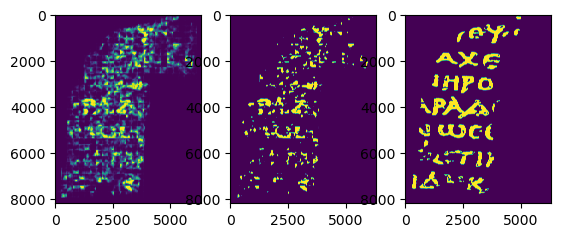

- epoch:13 -
Epoch: [13][0/125] Elapsed 0m 0s (remain 1m 51s) Loss: 0.1643(0.1643) 
Epoch: [13][124/125] Elapsed 0m 34s (remain 0m 0s) Loss: 0.1478(0.1760) 
EVAL: [0/31] Elapsed 0m 0s (remain 0m 9s) Loss: 0.2053(0.2053) 
EVAL: [30/31] Elapsed 0m 5s (remain 0m 0s) Loss: 0.1375(0.3966) 
	 th: 0.1, fbeta: 0.34149006926155767
	 th: 0.15, fbeta: 0.3661156478401964
	 th: 0.2, fbeta: 0.38737035661350566
	 th: 0.25, fbeta: 0.40657058766709514
	 th: 0.3, fbeta: 0.42299312626392027
	 th: 0.35, fbeta: 0.4379483588865712
	 th: 0.4, fbeta: 0.45226425902188366
	 th: 0.45, fbeta: 0.4667352627317842
	 th: 0.5, fbeta: 0.48207110771496015
	 th: 0.55, fbeta: 0.49643899964936744
	 th: 0.6, fbeta: 0.5069983888413402
	 th: 0.65, fbeta: 0.5110632153229511
	 th: 0.7, fbeta: 0.5095024356519539
	 th: 0.75, fbeta: 0.4979640632699597
	 th: 0.8, fbeta: 0.47148797581197927
	 th: 0.85, fbeta: 0.4259614042626955
	 th: 0.9, fbeta: 0.3551095809103832
	 th: 0.95, fbeta: 0.24767361199298277
	 th: 1.0, fbeta: 0.0
	 epoch:

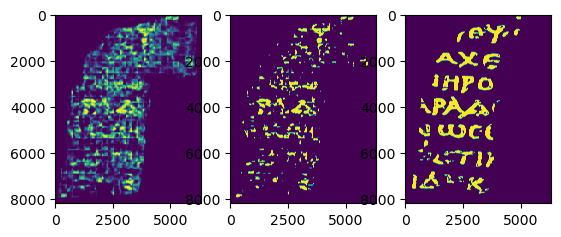

- epoch:14 -
Epoch: [14][0/125] Elapsed 0m 0s (remain 1m 53s) Loss: 0.1652(0.1652) 
Epoch: [14][124/125] Elapsed 0m 34s (remain 0m 0s) Loss: 0.1904(0.1753) 
EVAL: [0/31] Elapsed 0m 0s (remain 0m 9s) Loss: 0.1462(0.1462) 
EVAL: [30/31] Elapsed 0m 5s (remain 0m 0s) Loss: 0.1792(0.4125) 
	 th: 0.1, fbeta: 0.3606905234067524
	 th: 0.15, fbeta: 0.3886029834364781
	 th: 0.2, fbeta: 0.415378638195447
	 th: 0.25, fbeta: 0.44049065792894865
	 th: 0.3, fbeta: 0.4613781897289913
	 th: 0.35, fbeta: 0.4774535951752033
	 th: 0.4, fbeta: 0.49108801406228214
	 th: 0.45, fbeta: 0.5005191777921676
	 th: 0.5, fbeta: 0.505846015006639
	 th: 0.55, fbeta: 0.5070014962881985
	 th: 0.6, fbeta: 0.5015819557459336
	 th: 0.65, fbeta: 0.491902290627209
	 th: 0.7, fbeta: 0.4785527747955505
	 th: 0.75, fbeta: 0.4593412861702909
	 th: 0.8, fbeta: 0.42931305275514126
	 th: 0.85, fbeta: 0.38305861241517014
	 th: 0.9, fbeta: 0.3095695032127705
	 th: 0.95, fbeta: 0.19738024134344037
	 th: 1.0, fbeta: 0.00518666629733116

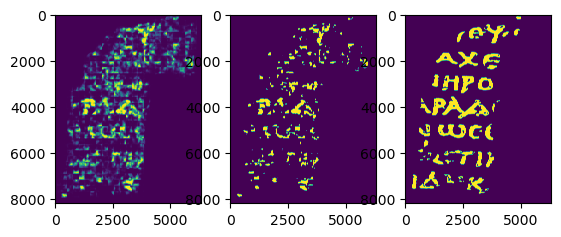

Epoch 15 - Save Best AUC: 0.8906. Model is saved.


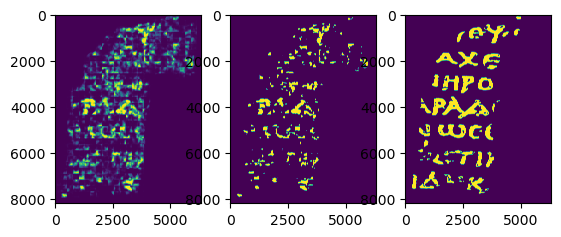

	 th: 0.1, fbeta: 0.3087443263643669
	 th: 0.15, fbeta: 0.3425011456313422
	 th: 0.2, fbeta: 0.37442140481650993
	 th: 0.25, fbeta: 0.40716866456173295
	 th: 0.3, fbeta: 0.4391517034215751
	 th: 0.35, fbeta: 0.4677115266858797
	 th: 0.4, fbeta: 0.4894471887595472
	 th: 0.45, fbeta: 0.5112772296539384
	 th: 0.5, fbeta: 0.5319131895544683
	 th: 0.55, fbeta: 0.5493999411876617
	 th: 0.6, fbeta: 0.5583484037974438
	 th: 0.65, fbeta: 0.5592519427997789
	 th: 0.7, fbeta: 0.5502171059428775
	 th: 0.75, fbeta: 0.529860701516787
	 th: 0.8, fbeta: 0.4997304218424406
	 th: 0.85, fbeta: 0.4551570282423611
	 th: 0.9, fbeta: 0.38500975185796404
	 th: 0.95, fbeta: 0.2853899019276884
	 th: 1.0, fbeta: 0.0


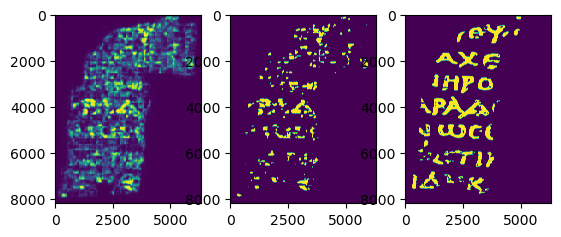

[fold2] slice ave score:0.5593(th=0.650000), auc=0.894528
[fold2] BEST Epoch 15 - Save Best Score:0.5412. Best loss:0.4060
[fold2] BEST AUC Epoch 15 - Save Best Score:0.8906. Best loss:0.4060
fold[0] BEST SCORE = 0.5641 thr=0.45 (epoch=12)
fold[0] slice ave score:0.5769(th=0.650000), auc=0.895672
fold[1] BEST SCORE = 0.3825 thr=0.45 (epoch=13)
fold[1] slice ave score:0.3830(th=0.150000), auc=0.784704
fold[2] BEST SCORE = 0.5412 thr=0.65 (epoch=15)
fold[2] slice ave score:0.5593(th=0.650000), auc=0.894528


In [49]:
best_score_list, best_threshold_list, best_epoch_list = training_loop(CFG)

In [50]:
import yaml
with open(os.path.join(CFG["OUTPUT_DIR"], "Config.yaml"), "w") as f:
    yaml.dump(CFG, f)

In [51]:
wandb.finish()